# Brightnes profiles for the deconvolved and initial polarimetric images

- radial profiles and check for the order of PSF smearing correction and deconvolution
- test for the possibility of calculation scattered light persentage from total intensity image

## Functions

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(12, 8))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
       
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = np.min([np.min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])
    vmax = np.max([np.max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1), int(n/2-lim1):int(n/2+lim1)]) for key in keys])

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6#6.8
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, -d, d), vmin=vmin, vmax=vmax,origin='lower')
        #plotting contour
        if arcsinh:
            levels=[np.arcsinh(np.max(data[key])/64),np.arcsinh(np.max(data[key])/32),np.arcsinh(np.max(data[key])/16),np.arcsinh(np.max(data[key])/8),np.arcsinh(np.max(data[key])/4),np.arcsinh(np.max(data[key])/2)]
        else:
            levels=[np.max(data[key])/64,np.max(data[key])/32,np.max(data[key])/16,np.max(data[key])/8,np.max(data[key])/4,np.max(data[key])/2]
        CS=ax.contour(data_arcshin[key], levels=levels,colors=['black', 'brown', 'red','purple','pink','white'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    #plt.show()
    
def LoadImage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data

            
    return fit

def LoadImage_dec (dir,annulus):

    files = os.listdir(dir)
    for fil in files:
        if fnmatch.fnmatch(fil, '*'+annulus+'_decon.fits'):
            hdu = fits.open(dir+fil)
            image = hdu[0].data
            ps =3.6
            n=image.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
    return image, R, x, y, d,x2,y2

def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
def load_I(dirdat,camera):
    dir = dirdat
    qfile = '*sci'+camera+'.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            hdulq = fits.open(dir + file)
            iq = hdulq[0].data[0]
            q = hdulq[0].data[1]
            iu = hdulq[0].data[2]
            u = hdulq[0].data[3]
            n=q.shape[0]
            i=(iq+iu)/2
            
    return iq,iu,i

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n

def plotImage(image, lim):
    n = image.shape[0]
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    # ax.set_xticks(np.arange(-lim*ps, lim*ps + 1, 100))
    plt.xlabel('mas', fontsize=20)
    plt.ylabel('mas', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)     
    plt.colorbar()
    plt.tight_layout
    return fig, ax
    
def Loadimages_notdeconv(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimages(dirdat,band, extension):
    dir = dirdat
    qfile = band+extension+'.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]
                
    return image, n


## Set up

In [126]:
stars=['01.SCI_AR_Pup']
ref_of_sci={'01.SCI_AR_Pup':'REF_HD75885','02.SCI_AR_Pup':'REF_HD74128','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals
disk_incl_pa={'02.SCI_AR_Pup':[75,45],'01.SCI_AR_Pup':[75,45],'UMon':[25,144],'UMon_Katya':[25,144],'V709_Car':[34,13],'HR4049_20190108':[49,63],'HR4049_20190107':[49,63],"HR4049_combined":[49,63],'HR4226':[0,1]} #Kluska_2019 for HR4049 V709Car, UMon from Andrych2023, AR Pup...have to check, this are from my table, HR4226 - just circle

star = stars[0]

incl_pa=disk_incl_pa[star]
fittypes=['1', '2']

band=['V','I']
ps=3.6
# ps=6.8
dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/'

normlim=120


In [127]:
PDI = None
DI = None

## Comparison of deconvolved data just after correction of telescope polarisation, without substraction of unresolved

In [128]:
PDI = True

In [129]:
camera = 'ZIMPOL/'
createfolder(dirdat0+'After_deconv_comp/')
figfolder=dirdat0+'After_deconv_comp/'+camera
createfolder(figfolder)
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera

In [130]:
import numpy as np

def crop_centered(image, target_height, target_width):
    """
    Crops a 2D NumPy array (image) to a specified target height and width,
    while keeping the center of the original image at the center of the cropped image.

    Args:
        image (np.ndarray): The 2D NumPy array representing the image to crop.
        target_height (int): The desired height of the cropped image.
        target_width (int): The desired width of the cropped image.

    Returns:
        np.ndarray: The cropped 2D NumPy array.
    """
    original_height, original_width = image.shape

    if target_height > original_height or target_width > original_width:
        raise ValueError("Target dimensions cannot be larger than original dimensions.")

    center_y = original_height // 2
    center_x = original_width // 2

    half_target_height = target_height // 2
    half_target_width = target_width // 2

    start_y = center_y - half_target_height
    end_y = center_y + half_target_height

    start_x = center_x - half_target_width
    end_x = center_x + half_target_width

    # Adjust for potential off-by-one errors due to integer division
    if (end_y - start_y) < target_height:
        if start_y > 0:
            start_y -= 1
        else:
            end_y += 1

    if (end_x - start_x) < target_width:
        if start_x > 0:
            start_x -= 1
        else:
            end_x += 1

    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image


In [79]:
if PDI == True:
    for fittype in fittypes:
        print(band[int(fittype)-1])
        output_filename = dirdat+star+'_'+band[int(fittype)-1]+'after_allcorr_stats.txt'
        with open(output_filename, 'w') as file_print:
            line="{:<30} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} ".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", "sumQ_phi/I[%]","sumPI/I[%]", 'sumIe6')
            #"{:<30} {:<10} {:<10} {:<10} {:<15}{:<10} {:<10} {:<10} {:<10}  \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi', "sumQ_phi/I[%]","sumPI/I[%]")

            print(line)
            file_print.write(line)

            dir =dirdat +'/deconvolved_'+'Q_phi'+'/'
            Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            dir =dirdat +'/deconvolved_'+'PI'+'/'
            PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            dir =dirdat +'/deconvolved_'+'I'+'/'
            I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            dir =dirdat +'/deconvolved_'+'DOLP'+'/'
            DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

            I=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'Unres+PSFcorr/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
            #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])


            frac =np.max(np.divide(PI_decon,I,where=I!=0)*(R<=150))*100
            mask=(R<=normlim)
            qphi_sum=np.sum(Q_phi_decon[mask])
            I_sum=np.sum(I[R<=1500/ps])
            pi_sum=np.sum(PI_decon[mask])


            line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  {:<10.5f}".format('deconvolved',
                frac, np.max(Q_phi_decon), np.max(PI_decon), qphi_sum/I_sum*100, pi_sum/I_sum*100,I_sum/10e6)
            print(line)
            file_print.write(line)


            if star!='01.SCI_AR_Pup':
                f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_qphi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
                f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'PSF_models/'+ref_of_sci[star]+'/',ref_of_sci[star]+band[int(fittype)-1]+'band_pi_ellipse_pa'+str(incl_pa[1])+'_i'+str(incl_pa[0])+'_f_psf_50.fits')
            elif star=='01.SCI_AR_Pup':
                f_q= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_qphi_circular_f_psf_50.fits')
                f_pi= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'PSF_models/'+ref_of_sci[star]+'/',band[int(fittype)-1]+'band_pi_circular_f_psf_50.fits')


            Q_phi_decon_smear=Q_phi_decon*f_q
            PI_decon_smear=PI_decon*f_pi



            frac =np.max(np.divide(PI_decon_smear,I,where=I!=0)*(R<=150))*100
            mask=(R<=normlim)
            qphi_sum=np.sum(Q_phi_decon_smear[mask])
            pi_sum=np.sum(PI_decon_smear[mask])

            line = "{:<30} {:<10.3f} {:<10.3f}  {:<10.3f} {:<10.3f} {:<10.3f}  ".format('deconvolved+smearing',
                frac, np.max(Q_phi_decon_smear), np.max(PI_decon_smear), qphi_sum/I_sum*100, pi_sum/I_sum*100)
            print(line)
            file_print.write(line)


        keys=['deconv+smearing','deconv']
        labels={'deconv+smearing':'deconv+smearing','deconv':'only deconv'}
        data={'deconv+smearing': Q_phi_decon_smear ,'deconv':Q_phi_decon}
        cameras=['ZIMPOL','ZIMPOL']
        plot_with_same_color(data, keys, labels ,'Q_phi',star+', PSF smearing test '+ref_of_sci[star]+', '+band[int(fittype)-1]+ ' band',10*ps,True,cameras)
        plt.savefig(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
        #plt.show()
        plt.close()





        out_fits = fits.HDUList(fits.PrimaryHDU(Q_phi_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_qphi_decon+PSF_smear.fits', overwrite = True)                       # write output
        out_fits = fits.HDUList(fits.PrimaryHDU(PI_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_pi_decon+PSF_smear.fits', overwrite = True)                       # write output

        DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)


        if band[int(fittype)-1]=='I':
            Q_phi_decon_I=Q_phi_decon
            PI_decon_I=PI_decon
            I_decon_I=I_decon
            DOLP_decon_I=DOLP_decon
            DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv
        if band[int(fittype)-1]=='V':
            Q_phi_decon_V=Q_phi_decon
            PI_decon_V=PI_decon
            I_decon_V=I_decon
            DOLP_decon_V=DOLP_decon
            DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv


    keys=['V','I']
    labels={'V':'V','I':'I'}
    cameras=['ZIMPOL','ZIMPOL']

    data={'V': Q_phi_decon_V ,'I':Q_phi_decon_I}
    plot_with_same_color(data, keys, labels ,'Q_phi deconvolved, ',star,8*ps,True,cameras)
    plt.savefig(figfolder+star+'_PI_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    data={'V': PI_decon_V ,'I':PI_decon_I}
    plot_with_same_color(data, keys, labels ,'PI deconvolved, ',star,8*ps,True,cameras)
    plt.savefig(figfolder+star+'_PI_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()


    data={'V': I_decon_V ,'I':I_decon_I}
    plot_with_same_color(data, keys, labels ,'I deconvolved, ',star,8*ps,True,cameras)
    plt.savefig(figfolder+star+'_I_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

    data={'V': DOLP_decon_V ,'I':DOLP_decon_I}
    plot_with_same_color(data, keys, labels ,'DOLP deconvolved, ',star,8*ps,False,cameras)
    plt.savefig(figfolder+star+'_DOLP_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    DOLP_calculated_after_deconv

    data={'V': DOLP_calculated_after_deconv_V ,'I':DOLP_calculated_after_deconv_I}
    plot_with_same_color(data, keys, labels ,'DOLP calculated after deconvolution, ',star,8*ps,False,cameras)
    plt.savefig(figfolder+star+'_DOLP_calc_after_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()


In [80]:
star

'02.SCI_AR_Pup'

V
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/02.SCI_AR_Pup_Vafter_allcorr_stats.txt
reference                      Peak_I(Strehl) sumIe6     
deconvolved                    5275.11151 0.11508   
02.SCI_AR_Pup
deconvolved+smearing           5275.112   0.115       
I
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/02.SCI_AR_Pup_Iafter_allcorr_stats.txt
reference                      Peak_I(Strehl) sumIe6     
deconvolved                    13013.03642 0.11712   
02.SCI_AR_Pup
deconvolved+smearing           13013.036  0.117       


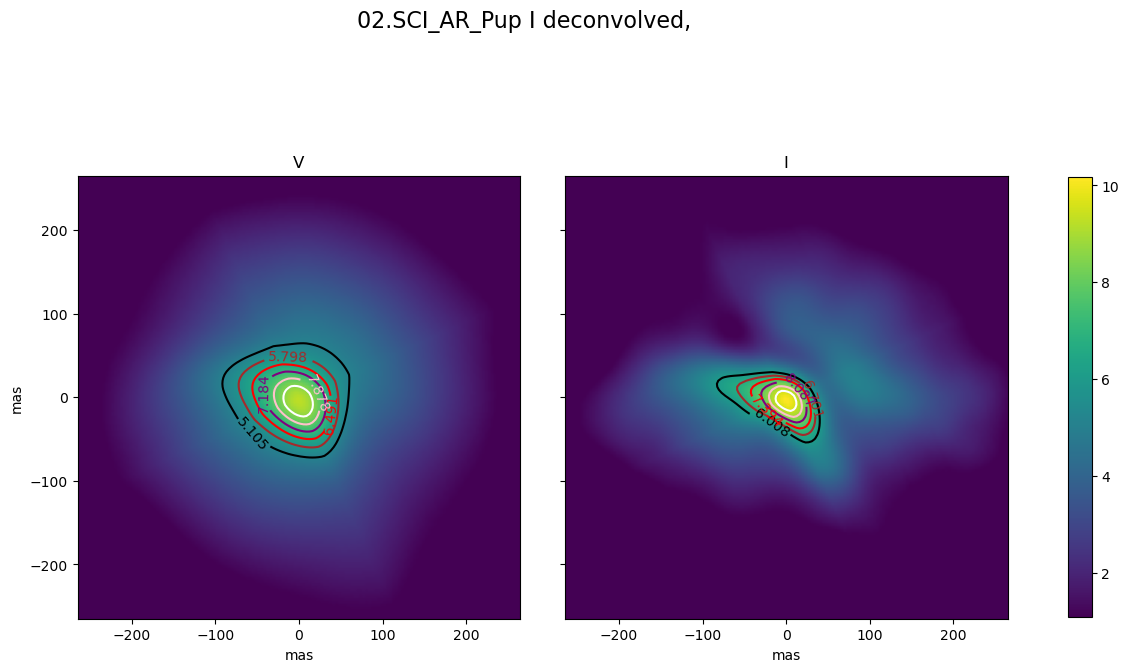

In [100]:
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/'
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/'

if DI == True:
    for fittype in fittypes:
        print(band[int(fittype)-1])
        output_filename = dirdat+star+'_'+band[int(fittype)-1]+'after_allcorr_stats.txt'
        print(output_filename)
        with open(output_filename, 'w') as file_print:
            line="{:<30} {:<10} {:<10} ".format('reference','Peak_I(Strehl)', 'sumIe6')
            #"{:<30} {:<10} {:<10} {:<10} {:<15}{:<10} {:<10} {:<10} {:<10}  \n".format('reference',"max_DoLP[%]", "max_Q_phi", "max_PI", 'Peak_I(Strehl)','Peak_PI','Peak_Qphi', "sumQ_phi/I[%]","sumPI/I[%]")

            print(line)
            file_print.write(line)

            # dir =dirdat +'/deconvolved_'+'Q_phi'+'/'
            # Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            # dir =dirdat +'/deconvolved_'+'PI'+'/'
            # PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            dir =dirdat +'/deconvolved_'+'I'+'/'
            I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
            # dir =dirdat +'/deconvolved_'+'DOLP'+'/'
            # DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])

            I=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
            #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])
            n=I.shape[0]
            d=(n-1)/2
            x = np.linspace(-d, d, n)
            y = np.linspace(-d, d, n)
            x2, y2 = np.meshgrid(x, y)
            R = np.sqrt(x2**2+y2**2)
            # frac =np.max(np.divide(I_decon,I,where=I!=0)*(R<=150))*100
            # mask=(R<=normlim)
            # qphi_sum=np.sum(Q_phi_decon[mask])
            I_sum=np.sum(I[R<=1500/ps])
            # pi_sum=np.sum(PI_decon[mask])


            line = "{:<30} {:<10.5f} {:<10.5f}".format('deconvolved', np.max(I_decon),I_sum/10e6)
            print(line)
            file_print.write(line)

            if star!='02.SCI_AR_Pup' or star!='01.SCI_AR_Pup':
                print(star)
                f_i= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',band[int(fittype)-1]+'band_i_circular_f_psf_50.fits')
            elif star=='02.SCI_AR_Pup' or star=='01.SCI_AR_Pup':
                f_i= LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/PSF_models/',band[int(fittype)-1]+'band_i_circular_f_psf_50.fits')

            #
            I_decon = crop_centered(I_decon,150,150)
            f_i = crop_centered(f_i,150,150)
            I_decon_smear=I_decon*f_i
            # PI_decon_smear=PI_decon*f_pi


            #
            # frac =np.max(np.divide(I_decon_smear,I,where=I!=0)*(R<=150))*100
            # mask=(R<=normlim)
            # qphi_sum=np.sum(Q_phi_decon_smear[mask])
            # pi_sum=np.sum(PI_decon_smear[mask])

            line = "{:<30} {:<10.3f} {:<10.3f}  ".format('deconvolved+smearing',
                 np.max(I_decon_smear), I_sum/10e6)
            print(line)
            file_print.write(line)


        keys=['deconv+smearing','deconv']
        labels={'deconv+smearing':'deconv+smearing','deconv':'only deconv'}
        data={'deconv+smearing': I_decon_smear ,'deconv':I_decon}
        cameras=['ZIMPOL','ZIMPOL']
        plot_with_same_color(data, keys, labels ,'I',star+', PSF smearing test '+ref_of_sci[star]+', '+band[int(fittype)-1]+ ' band',10*ps,True,cameras)
        plt.savefig(figfolder+band[int(fittype)-1]+'band_i_decon+PSF_smear.png',bbox_inches='tight', pad_inches=0.1)
        #plt.show()
        plt.close()


        out_fits = fits.HDUList(fits.PrimaryHDU(I_decon_smear))                  # create output fits structure
        out_fits.writeto(figfolder+band[int(fittype)-1]+'band_i_decon+PSF_smear.fits', overwrite = True)                       # write output
        # out_fits = fits.HDUList(fits.PrimaryHDU(PI_decon_smear))                  # create output fits structure
        # out_fits.writeto(figfolder+band[int(fittype)-1]+'band_pi_decon+PSF_smear.fits', overwrite = True)                       # write output

        # DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)


        if band[int(fittype)-1]=='I':
            # Q_phi_decon_I=Q_phi_decon
            # PI_decon_I=PI_decon
            I_decon_I=I_decon
            # DOLP_decon_I=DOLP_decon
            # DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv
        if band[int(fittype)-1]=='V':
            # Q_phi_decon_V=Q_phi_decon
            # PI_decon_V=PI_decon
            I_decon_V=I_decon
            # DOLP_decon_V=DOLP_decon
            # DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv


    keys=['V','I']
    labels={'V':'V','I':'I'}
    cameras=['ZIMPOL','ZIMPOL']

    middle = 1024/2
    data={'V': I_decon_V ,'I':I_decon_I}
    plot_with_same_color(data, keys, labels ,'I deconvolved, ',star,6*ps,True,cameras)
    plt.savefig(figfolder+star+'_I_deconv_both_bands.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [273]:
bands = ['I','V']
fittypes = ['1','2']

V
V's


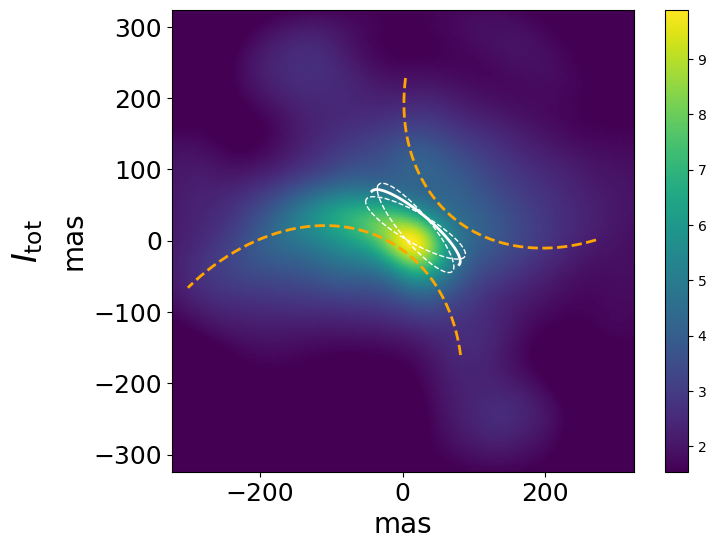

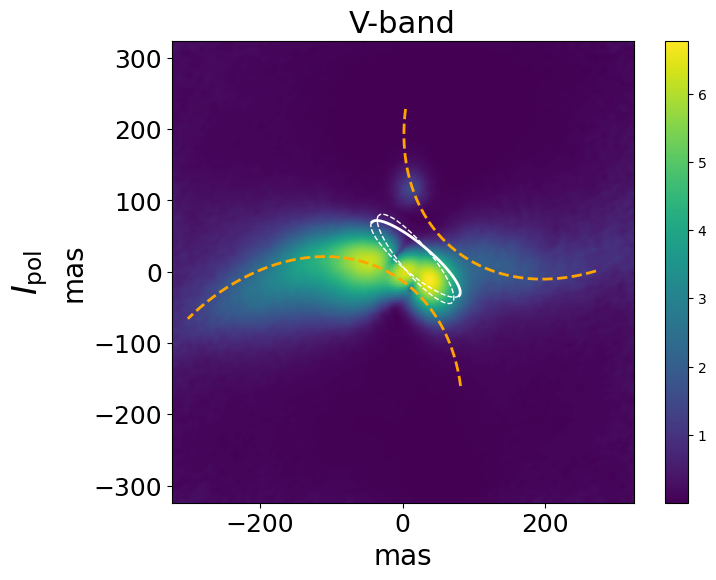

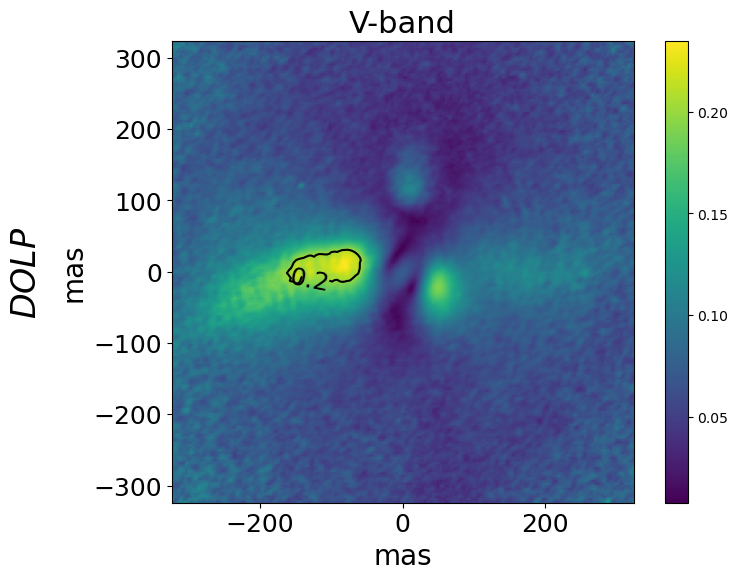

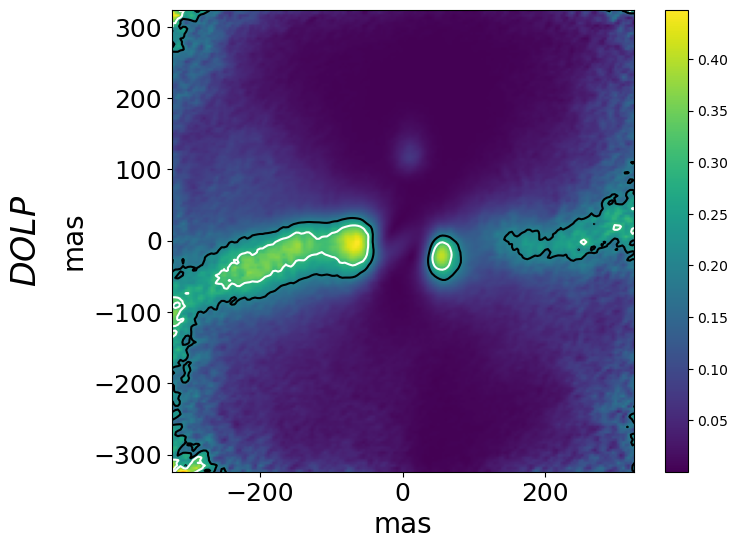

I


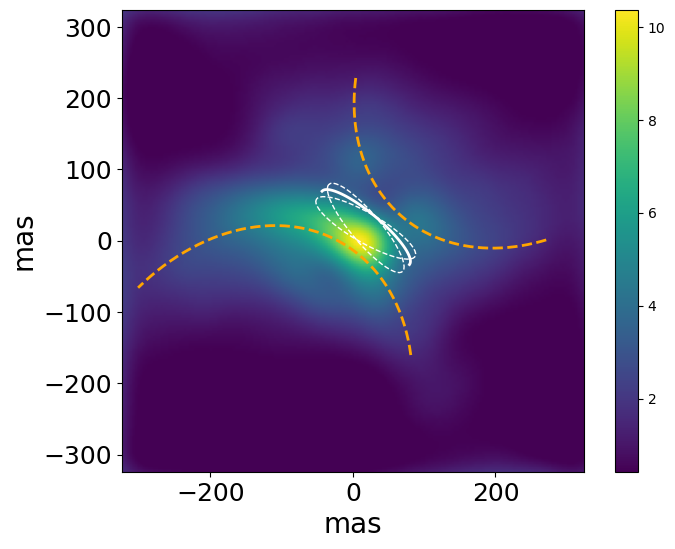

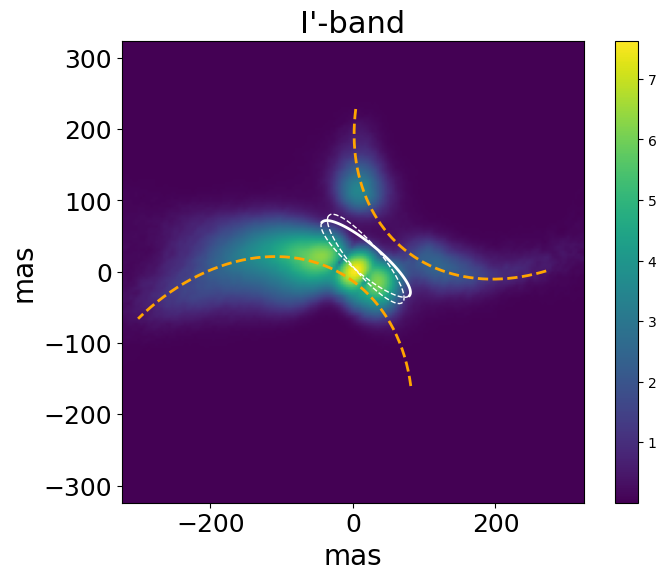

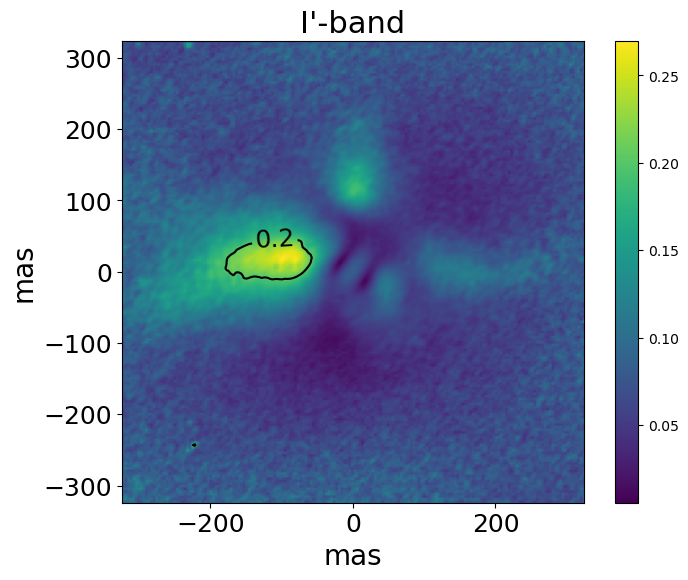

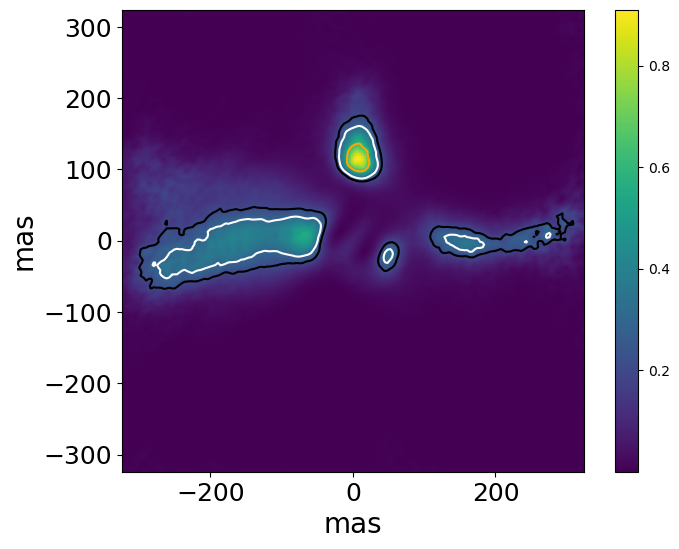

In [134]:
# PDI = True

if PDI == True:
    def plotImage_lin(image, lim):
        n = image.shape[0]
        fig, ax = plt.subplots(figsize=(8,6))
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ps = 3.6 #mas per pixel for zimpol
        d = n * ps / 2
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas', fontsize=20)
        plt.ylabel('mas', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        plt.colorbar()
        plt.tight_layout
        return fig, ax

    dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/ZIMPOL'
    for fittype in fittypes:
        print(band[int(fittype)-1])

        dir =dirdat +'/deconvolved_'+'Q_phi'+'/'
        Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'PI'+'/'
        PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'I'+'/'
        I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        # dir =dirdat +'/deconvolved_'+'DOLP'+'/'
        # DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])


        PI=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/',star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
        I=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])



        DOLP_decon=np.divide(PI,I,where=I!=0)

        DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)
        DOLP=np.divide(PI,I,where=I!=0)


        if band[int(fittype)-1]=='I':
            Q_phi_decon_I=Q_phi_decon
            PI_decon_I=PI_decon
            I_decon_I=I_decon
            DOLP_decon_I=DOLP_decon
            DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv

        if band[int(fittype)-1]=='V':
            print("V's")
            Q_phi_decon_V=Q_phi_decon
            PI_decon_V=PI_decon
            I_decon_V=I_decon
            DOLP_decon_V=DOLP_decon
            DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv



        ell = EllipseModel()

        #substructures
        xcs=ycs=73
        a=300/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(50)

        points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))

        xcs=43+3
        ycs=68+5
        a=300/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(60)

        points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs,-ycs,a,b,theta))

        xc=yc=5
        a=80/ps
        b=a*np.cos(np.deg2rad(75))
        theta=np.deg2rad(50+90)

        fig,ax=plotImage(I_decon, 90)
        #if band[int(fittype)-1]=='I':
        #    plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        #
        #else:
        #    plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        if band[int(fittype)-1]=='V':
            ax.text(-0.35, 0.5,r'$I_{\rm tot}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)

        points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
        points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))

        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        # plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_I_deconv.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        fig,ax=plotImage(PI_decon, 90)
        if band[int(fittype)-1]=='I':
            plt.title(band[int(fittype)-1]+"'-band", fontsize=22)

        else:
            plt.title(band[int(fittype)-1]+"-band", fontsize=22)
            ax.text(-0.35, 0.5,r'$I_{\rm pol}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)

        points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
        points_dash=ell.predict_xy(np.linspace(0,  np.pi, 50),params=(xc,yc,a,b,theta))
        points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))

        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_PI_deconv.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        n=DOLP.shape[0]
        d = n * ps / 2

        fig,ax=plotImage_lin(DOLP, 90)
        levels=[0.2,0.30,0.6]
        CS=ax.contour(DOLP, levels=levels,colors=['black','white','orange'], extent=(-d, d, -d, d))
        ax.clabel(CS, inline=True, fontsize=18)

        if band[int(fittype)-1]=='I':
            plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        else:
            plt.title(band[int(fittype)-1]+"-band", fontsize=22)
            ax.text(-0.35, 0.5,r'$DOLP$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_DOLP.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        fig,ax=plotImage_lin(DOLP_calculated_after_deconv, 90)
        levels=[0.2,0.3,0.6]
        CS=ax.contour(DOLP_calculated_after_deconv, levels=levels,colors=['black','white','orange'], extent=(-d, d, -d, d))
        #ax.clabel(CS, inline=True, fontsize=18)

        # if band[int(fittype)-1]=='I':
        #     plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        # else:
        #     plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        if band[int(fittype)-1]=='V':
            ax.text(-0.35, 0.5,r'$DOLP$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_DOLP_decon.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()




V


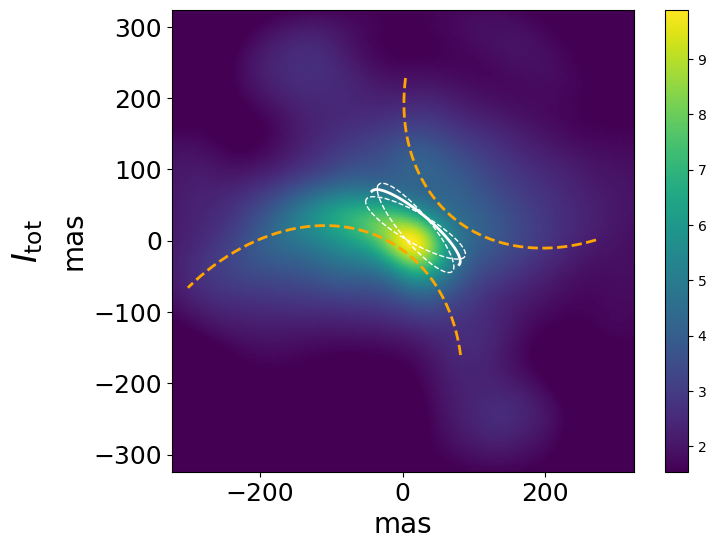

I


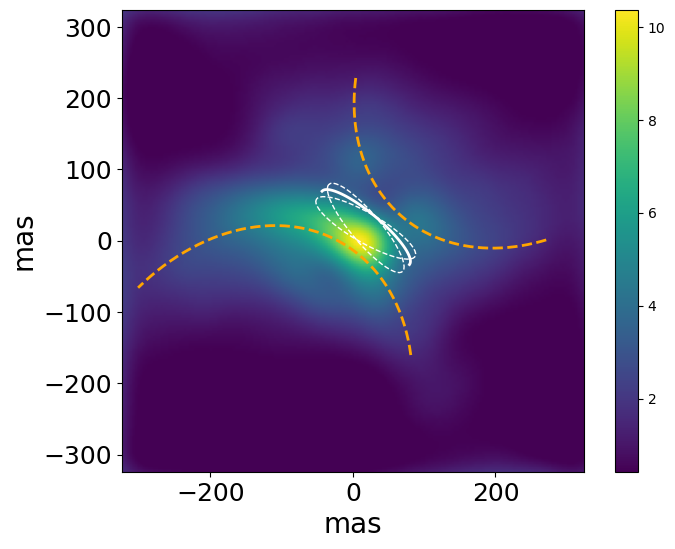

In [146]:
# I tot only

def plotImage_it(image, lim):
    n = image.shape[0]
    fig, ax = plt.subplots(figsize=(8,6))
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=20)
    plt.ylabel('mas', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    plt.colorbar()
    plt.tight_layout
    return fig, ax

if PDI == True:
    dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/ZIMPOL'

    for fittype in fittypes:
        print(band[int(fittype)-1])

        dir = dirdat + '/deconvolved_' + 'I' + '/'
        I_decon, R, x, y, d_in, X, Y = LoadImage_dec(dir, band[int(fittype)-1])

        if band[int(fittype)-1] == 'I':
            I_decon_I = I_decon
        if band[int(fittype)-1] == 'V':
            I_decon_V = I_decon

        # Define ellipses for overlay
        from skimage.measure import EllipseModel
        ell = EllipseModel()

        xcs = ycs = 73
        a = 300 / ps
        b = a * np.cos(np.deg2rad(40))
        theta = np.deg2rad(50)
        points_subtr1 = ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50), params=(xcs, ycs, a, b, theta))

        xcs = 43 + 3
        ycs = 68 + 5
        a = 300 / ps
        b = a * np.cos(np.deg2rad(40))
        theta = np.deg2rad(60)
        points_subtr2 = ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50), params=(-xcs, -ycs, a, b, theta))

        xc = yc = 5
        a = 80 / ps
        b = a * np.cos(np.deg2rad(75))
        theta = np.deg2rad(140)

        fig, ax = plotImage_it(I_decon, 90)

        if band[int(fittype)-1] == 'V':
            ax.text(-0.35, 0.5, r'$I_{\rm tot}$', transform=ax.transAxes, fontsize=24, va='center', rotation=90)

        points = ell.predict_xy(np.linspace(np.pi, 2*np.pi, 50), params=(xc, yc, a, b, theta))
        points_plus = ell.predict_xy(np.linspace(0, 2*np.pi, 50), params=(xc, yc, a, b, theta + np.deg2rad(10)))
        points_minus = ell.predict_xy(np.linspace(0, 2*np.pi, 50), params=(xc, yc, a, b, theta - np.deg2rad(10)))

        plt.plot(points[:, 0]*ps, points[:, 1]*ps, lw=2, color='white')
        plt.plot(points_plus[:, 0]*ps, points_plus[:, 1]*ps, lw=1, ls='--', color='white')
        plt.plot(points_minus[:, 0]*ps, points_minus[:, 1]*ps, lw=1, ls='--', color='white')
        plt.plot(points_subtr1[:, 0]*ps, points_subtr1[:, 1]*ps, lw=2, ls='--', color='orange')
        plt.plot(points_subtr2[:, 0]*ps, points_subtr2[:, 1]*ps, lw=2, ls='--', color='orange')

        plt.savefig(figfolder + star + '_' + band[int(fittype)-1] + '_I_deconv.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


In [117]:
DI = True

V
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOL/


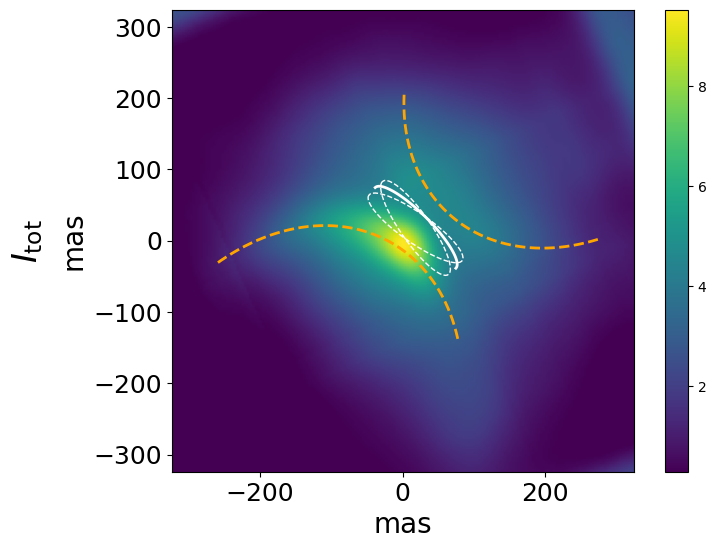

I
/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/


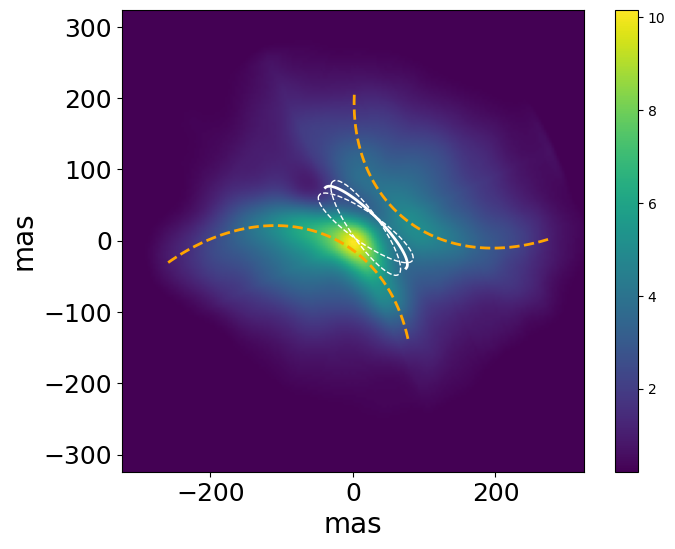

In [125]:
if DI == True:
    def plotImage_lin(image, lim):
        n = image.shape[0]
        fig, ax = plt.subplots(figsize=(8,6))
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ps = 3.6 #mas per pixel for zimpol
        d = n * ps / 2
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas', fontsize=20)
        plt.ylabel('mas', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        plt.colorbar()
        plt.tight_layout
        return fig, ax

    # dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_telv1/ZIMPOLv2/'
    for fittype in fittypes:

        # print(fittype)

        if band[int(fittype)-1]=='I': dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_telv1/ZIMPOLv2/'
        if band[int(fittype)-1]=='V': dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_telv1/ZIMPOL/'

        print(band[int(fittype)-1])
        print(dirdat)

        # dir =dirdat +'/deconvolved_'+'Q_phi'+'/'
        # Q_phi_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        # dir =dirdat +'/deconvolved_'+'PI'+'/'
        # PI_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        dir =dirdat +'/deconvolved_'+'I'+'/'
        I_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])
        # dir =dirdat +'/deconvolved_'+'DOLP'+'/'
        # DOLP_decon, R, x, y, d_in,X,Y= LoadImage_dec(dir,band[int(fittype)-1])


        # PI=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'+'Unres+PSFcorr/'+star+'/',star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
        I=LoadImage('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/',star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        #PSF,n= Loadimagespsf(ref_of_sci[star],'/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/'+ref_of_sci[star]+'/filtered/',band[int(fittype)-1])


        # DOLP_calculated_after_deconv=np.divide(PI_decon,I_decon,where=I_decon!=0)
        # DOLP=np.divide(PI,I,where=I!=0)


        if band[int(fittype)-1]=='I':
            # Q_phi_decon_I=Q_phi_decon
            # PI_decon_I=PI_decon
            I_decon_I=I_decon
            # DOLP_decon_I=DOLP_decon
            # DOLP_calculated_after_deconv_I=DOLP_calculated_after_deconv

        if band[int(fittype)-1]=='V':
            # Q_phi_decon_V=Q_phi_decon
            # PI_decon_V=PI_decon
            I_decon_V=I_decon
            # DOLP_decon_V=DOLP_decon
            # DOLP_calculated_after_deconv_V=DOLP_calculated_after_deconv



        ell = EllipseModel()

        #substructures
        # top arc
        xcs=ycs=73
        a=300/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(50)

        points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(135), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))
        # bottom arc
        xcs=43+3
        ycs=68+5
        a=300/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(60)

        points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-40), np.deg2rad(60), 50),params=(-xcs,-ycs,a,b,theta))

        # white
        xc=yc=5
        a=80/ps
        b=a*np.cos(np.deg2rad(75))
        theta=np.deg2rad(45+90)

        fig,ax=plotImage(I_decon, 90)
        #if band[int(fittype)-1]=='I':
        #    plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        #
        #else:
        #    plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        if band[int(fittype)-1]=='V':
            ax.text(-0.35, 0.5,r'$I_{\rm tot}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)

        points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
        points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))

        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        # plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_I_deconv.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()


        # # fig,ax=plotImage(PI_decon, 100)
        # if band[int(fittype)-1]=='I':
        #     plt.title(band[int(fittype)-1]+"'-band", fontsize=22)
        #
        # else:
        #     plt.title(band[int(fittype)-1]+"-band", fontsize=22)
        #     ax.text(-0.35, 0.5,r'$I_{\rm pol}$' , transform=ax.transAxes, fontsize=24, va='center', rotation=90)
        #
        # points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
        # points_dash=ell.predict_xy(np.linspace(0,  np.pi, 50),params=(xc,yc,a,b,theta))
        # points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        # points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))
        #
        # plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        # plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
        # #plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        # plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        # plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')
        #
        # plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_ellipse_deconv.png',bbox_inches='tight', pad_inches=0.1)
        # plt.show()
        # plt.close()




#### IRDIS DI

H


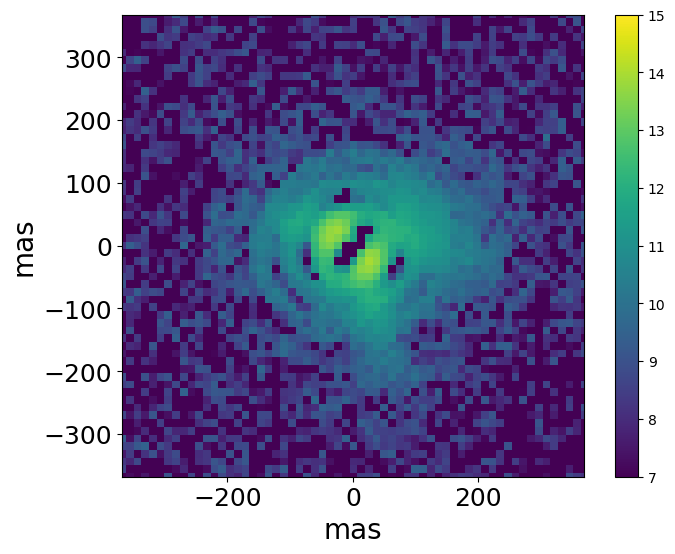

In [253]:
DI = True
ps = 12.27

if DI == True:

    def plotImage_I(image, lim,max,min):
        n = image.shape[0]
        fig, ax = plt.subplots(figsize=(8,6))
        image = np.arcsinh(image)
        maxs = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        mins=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ps = 12.27 #mas per pixel for zimpol
        d = n * ps / 2
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas', fontsize=20)
        plt.ylabel('mas', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        plt.colorbar()
        plt.tight_layout

        return fig, ax

    def LoadImage_ird (dir):
        hdu = fits.open(dir)
        image = hdu[0].data
        ps =12.27
        n=image.shape[0]
        d=(n-1)/2
        x = np.linspace(-d, d, n)
        y = np.linspace(-d, d, n)
        x2, y2 = np.meshgrid(x, y)
        R = np.sqrt(x2**2+y2**2)

        return image, R, x, y, d,x2,y2

    fittypes = ['H']

    for fittype in fittypes:
        print(fittype)
        # del I_decon, R, x, y, d_in,X,Y
        I_decon, R, x, y, d_in,X,Y = LoadImage_ird('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/IRDIS/2016/16.0/combined_ArP2016_IRDIS.fits')


        ell = EllipseModel()

        #substructures

        # orange arc right
        xcs=ycs=17
        a=250/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(50)


        points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))

        # arc left
        xcs=11+3
        ycs=11+5
        a=250/ps
        b=a*np.cos(np.deg2rad(40))
        theta=np.deg2rad(60)

        points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs,-ycs,a,b,theta))

        # white
        xc=yc=1
        a=60/ps
        b=a*np.cos(np.deg2rad(75))
        theta=np.deg2rad(50+90)

        fig,ax=plotImage_I(I_decon, 30, 15,7)

        # # white
        # points=ell.predict_xy(np.linspace(np.pi,  2*np.pi, 50),params=(xc,yc,a,b,theta))
        # points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        # points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))
        #
        # plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        # # plt.plot(points_dash[:,0]*ps,points_dash[:,1]*ps, lw=1,ls='--', color='white')
        # plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
        # plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        # plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        # plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')
        #
        # plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/IRDIS/'+'01.SCI_AR_Pup'+'_H_I_deconv.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()



## Radial brightness profile

In [33]:
radial_prof=True
if radial_prof:
    def Loadimagespsf(star,dirdat,band):
        dir = dirdat
        qfile = '*_'+band+'_I_meancombined.fits'
        files = os.listdir(dir)
        image=[]
        for file in files:
            if fnmatch.fnmatch(file, qfile):
                with fits.open(dir + file) as hdul:
                    image = hdul[0].data
                    n = image.shape[0]

                    print(n)
        return image, n

    def Loadimages(star,fittype,dirdat,band, extension):
        dir = dirdat
        qfile = '*'+band+'_'+fittype+extension+'.fits'
        files = os.listdir(dir)
        image=[]
        for file in files:
            if fnmatch.fnmatch(file, qfile):

                with fits.open(dir + file) as hdul:
                    image = hdul[0].data
                    n = image.shape[0]

        return image, n



    def plotImage(image, lim):
        n = image.shape[0]

        fig, ax = plt.subplots(figsize=(8,6))
        image = np.arcsinh(image)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        ps = 3.6 #mas per pixel for zimpol
        d = n * ps / 2
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
        #plt.plot(0, 0, "+", color="red")
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)
        plt.xlabel('mas',fontsize=18)
        plt.ylabel("mas",fontsize=18)
        plt.colorbar()


    import functions as f


    dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/After_deconv/'

    dirdat='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'
    figfolder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/scattered/'
    createfolder(figfolder)
    figfolder=figfolder+star+'/'
    createfolder(figfolder)


    #dirdat = '//media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/individual_cycles/IRAS08544-4431/Not_normalised/corr_with_ref/tel+unresol+PSF_smearing/Andrych2023/'  #For IRAS08
    xc=511.5
    yc=511.5


In [ ]:
PDI = True

In [34]:
if PDI == True:
      for fittype in fittypes:

        I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'filtered/'+ref_of_sci[star]+'/',band[int(fittype)-1])
        PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
        PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
        #U=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'U_phi'+'_meancombined.fits')
        Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdat, band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear')

        mask=(R<=500/ps)
        PSF=PSF#$/np.sum(PSF[mask])*10e6
        #print(np.max(I[mask]))
        #print(np.max(PI[mask]))


        norm=np.max(PI[mask])
        #PSF=PSF*norm

        I=I/np.max(I[mask])
        PSF=PSF/np.max(PSF[mask])
        #I=I/norm
        PI=PI/norm
        Qphi=Qphi/np.max(Qphi)
        #PI_unres=PI_unres/norm

        #radial_brightness

        xr = np.linspace(0, n, num=n)
        yr = np.linspace(0, n, num=n)
        xr = xr-xc
        yr = yr-yc
        Xr, Yr = np.meshgrid(xr, yr)
        R=np.sqrt(Xr**2 + (Yr)**2)
        r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
        pos_angle=np.rad2deg(pos_angle)+180


        I_mean_ar=[]
        PSF_mean_ar=[]
        PI_mean_ar=[]
        PI_unres_mean_ar=[]
        Qphi_mean_ar=[]
        #var_ar=[]
        for i_r in range (2,80,2):

            width=math.sqrt(i_r)/2
            mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
            image_I=I[mask]
            image_PI=PI[mask]
            image_PSF=PSF[mask]
            image_PI_unres=PI_unres[mask]
            image_Qphi=Qphi[mask]
           # image_u=U[mask]
            #error=np.nanstd(image_u)/math.sqrt(len(image_u))/np.max(PI[mask])


            i_r_stop=i_r
            I_mean=np.mean(image_I)
            PSF_mean=np.mean(image_PSF)
            I_mean_ar.append(I_mean)
            PSF_mean_ar.append(PSF_mean)
            PI_mean=np.mean(image_PI)
            PI_mean_ar.append(PI_mean)
            PI_unres_mean=np.mean(image_PI_unres)
            PI_unres_mean_ar.append(PI_unres_mean)
            Qphi_mean=np.mean(image_Qphi)
            Qphi_mean_ar.append(Qphi_mean)
           # var_ar.append(error)




        i_rad=[float(x)*ps for x in range (2,i_r_stop+1,2)]
        #plt.plot(i_rad,q_mean)
        #print(len(i_rad),len(q_mean_ar),len(var_ar))

        fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
        plt.errorbar(i_rad,PSF_mean_ar, label=r'$I_{\rm tot}$, ref. star',fmt='--s', markersize=8)
        plt.errorbar(i_rad,I_mean_ar, label=r'$I_{\rm tot}$, '+'AR Pup', fmt='-.o', markersize=8)
        plt.errorbar(i_rad,PI_mean_ar, label=r'$I_{\rm pol}$, '+'AR Pup', fmt='-v', markersize=9)
        plt.ylabel(r'X/max(X)', fontsize=20)
        plt.xlabel('Distance from the star, mas', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if band[int(fittype)-1]=='I':
            plt.title(band[int(fittype)-1]+"'-band",fontsize=20)
        else:
            plt.title(band[int(fittype)-1]+"-band",fontsize=20)
        plt.legend(fontsize=18)
        plt.yscale('log')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_scattered.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        scattered=I-PSF
        scattered_pos=scattered*(scattered>=0)+1e-15*(scattered<0)



        Iscat_full=np.sum(scattered_pos*(R<=i_r))/np.sum(I*(R<=1500/ps))
        print('for pixel to pixel I-PSF  %',Iscat_full*100)


In [289]:
figfolder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Substructures/'

In [35]:
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/filtered/'

In [28]:
if DI == True:
      for fittype in fittypes:

        I=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'I'+'_meancombined.fits')
        PSF,n= Loadimagespsf(ref_of_sci[star],'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/',band[int(fittype)-1])
        # PI_unres, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_'+'tel+unres')
        # PI=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'PI'+'_meancombined.fits')
        # #U=LoadImage(dirdat,star+'_'+band[int(fittype)-1]+'_'+'U_phi'+'_meancombined.fits')
        # Qphi, n=Loadimages_notdeconv(star,'Q_phi',dirdat, band[int(fittype)-1],'_corr_smearing_tel+unres+PSF_smear')

        R = crop_centered(R,1024,1024)
        mask=(R<=100/ps)
        PSF=PSF#$/np.sum(PSF[mask])*10e6
        #print(np.max(I[mask]))
        #print(np.max(PI[mask]))


        # norm=np.max(PI[mask])
        #PSF=PSF*norm

        I=I/np.max(I[mask])
        # PSF=PSF/np.max(PSF[mask])
        #I=I/norm
        # PI=PI/norm
        # Qphi=Qphi/np.max(Qphi)
        #PI_unres=PI_unres/norm

        #radial_brightness

        xr = np.linspace(0, n, num=n)
        yr = np.linspace(0, n, num=n)
        xr = xr-xc
        yr = yr-yc
        Xr, Yr = np.meshgrid(xr, yr)
        R=np.sqrt(Xr**2 + (Yr)**2)
        r, pos_angle = f.cart2polar_for_mask_defining(Xr, Yr)
        pos_angle=np.rad2deg(pos_angle)+180


        I_mean_ar=[]
        # PSF_mean_ar=[]
        # PI_mean_ar=[]
        # PI_unres_mean_ar=[]
        # Qphi_mean_ar=[]
        #var_ar=[]
        for i_r in range (2,80,2):

            width=math.sqrt(i_r)/2
            mask = (R < i_r+width) & (R >=(i_r-width))# & (pos_angle>startang)& (pos_angle<endang)
            image_I=I[mask]
            # image_PI=PI[mask]
            # image_PSF=PSF[mask]
            # image_PI_unres=PI_unres[mask]
            # image_Qphi=Qphi[mask]
           # image_u=U[mask]
            #error=np.nanstd(image_u)/math.sqrt(len(image_u))/np.max(PI[mask])


            i_r_stop=i_r
            I_mean=np.mean(image_I)
            # PSF_mean=np.mean(image_PSF)
            I_mean_ar.append(I_mean)
            # PSF_mean_ar.append(PSF_mean)
            # PI_mean=np.mean(image_PI)
            # PI_mean_ar.append(PI_mean)
            # PI_unres_mean=np.mean(image_PI_unres)
            # PI_unres_mean_ar.append(PI_unres_mean)
            # Qphi_mean=np.mean(image_Qphi)
            # Qphi_mean_ar.append(Qphi_mean)
           # var_ar.append(error)




        i_rad=[float(x)*ps for x in range (2,i_r_stop+1,2)]
        #plt.plot(i_rad,q_mean)
        #print(len(i_rad),len(q_mean_ar),len(var_ar))

        fig, (ax1) = plt.subplots(1, 1,figsize=(8,7))
        # plt.errorbar(i_rad,PSF_mean_ar, label=r'$I_{\rm tot}$, ref. star',fmt='--s', markersize=8)
        plt.errorbar(i_rad,I_mean_ar, label=r'$I_{\rm tot}$, '+'AR Pup', fmt='-.o', markersize=8)
        # plt.errorbar(i_rad,PI_mean_ar, label=r'$I_{\rm pol}$, '+'AR Pup', fmt='-v', markersize=9)
        plt.ylabel(r'X/max(X)', fontsize=20)
        plt.xlabel('Distance from the star, mas', fontsize=20)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if band[int(fittype)-1]=='I':
            plt.title(band[int(fittype)-1]+"'-band",fontsize=20)
        else:
            plt.title(band[int(fittype)-1]+"-band",fontsize=20)
        plt.legend(fontsize=18)
        plt.yscale('log')

        plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_scattered.png',bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

        scattered=I-PSF
        scattered_pos=scattered*(scattered>=0)+1e-15*(scattered<0)


        Iscat_full=np.sum(scattered_pos*(R<=i_r))/np.sum(I*(R<=1500/ps))
        print('for pixel to pixel I-PSF  %',Iscat_full*100)


UnboundLocalError: cannot access local variable 'fit' where it is not associated with a value

## Comparing Profile b/w epochs

### 2018 Data below:

In [147]:
def plot_circle_overlay(image_data, band_label, output_path, peak_x, peak_y,
                        plate_scale, separation_pixels, zoom_half_width_mas):
    """Plots an image with an azimuthal profile circle and compass + scale bar."""
    ny, nx = image_data.shape
    display_image = np.arcsinh(image_data)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(display_image, origin='lower', cmap='viridis',
              vmin=0, vmax=10,
              extent=(-nx/2 * plate_scale, nx/2 * plate_scale,
                      -ny/2 * plate_scale, ny/2 * plate_scale))

    # Circle coordinates
    theta = np.linspace(0, 2*np.pi, 360)
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta)
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale

    ax.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_pixels * plate_scale:.0f} mas circle')
    ax.plot(0, 0, 'rx', markersize=10, label='Image Center')

    ax.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_title(f'Deconvolved AR Pup {band_label} band', fontsize=16)
    ax.grid(False)

    # Compass
    padding = 0.05 * zoom_half_width_mas
    arrow_length = 0.15 * zoom_half_width_mas
    head_width = 0.05 * arrow_length
    head_length = 0.1 * arrow_length
    base_x = zoom_half_width_mas - padding
    base_y = -zoom_half_width_mas + padding

    ax.arrow(base_x, base_y, 0, arrow_length,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x, base_y + arrow_length + 0.1 * arrow_length,
            'N', color='white', ha='center', va='bottom', fontsize=10)

    ax.arrow(base_x, base_y, -arrow_length, 0,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x - arrow_length - 0.2 * arrow_length, base_y,
            'E', color='white', ha='right', va='center', fontsize=10)

    # Scale bar
    scale_length = 100
    pad_x = 0.05 * zoom_half_width_mas
    pad_y = 0.08 * zoom_half_width_mas
    bar_x = -zoom_half_width_mas + pad_x
    bar_y = -zoom_half_width_mas + pad_y

    ax.plot([bar_x, bar_x + scale_length],
            [bar_y, bar_y], 'w-', linewidth=3, zorder=10)
    ax.text(bar_x + scale_length / 2, bar_y - (0.02 * zoom_half_width_mas),
            f'{scale_length} mas',
            color='white', ha='center', va='top', fontsize=10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close(fig)

<Figure size 640x480 with 0 Axes>

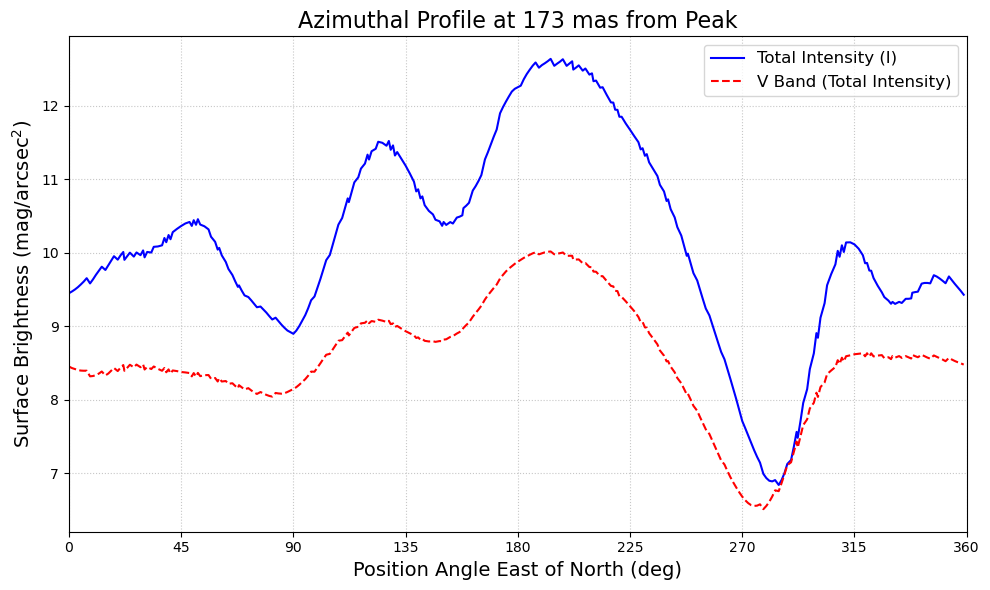

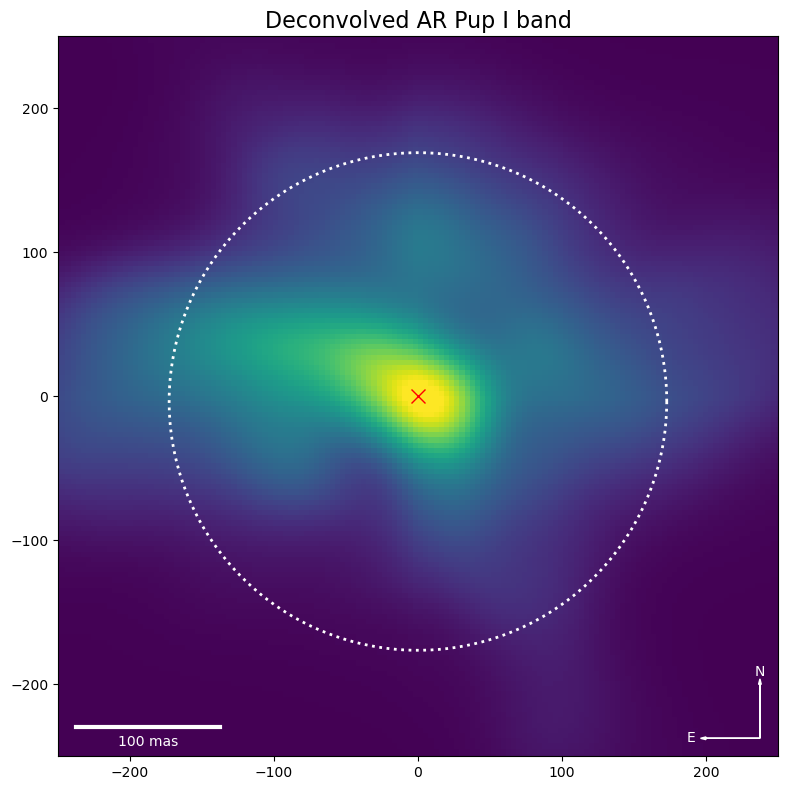

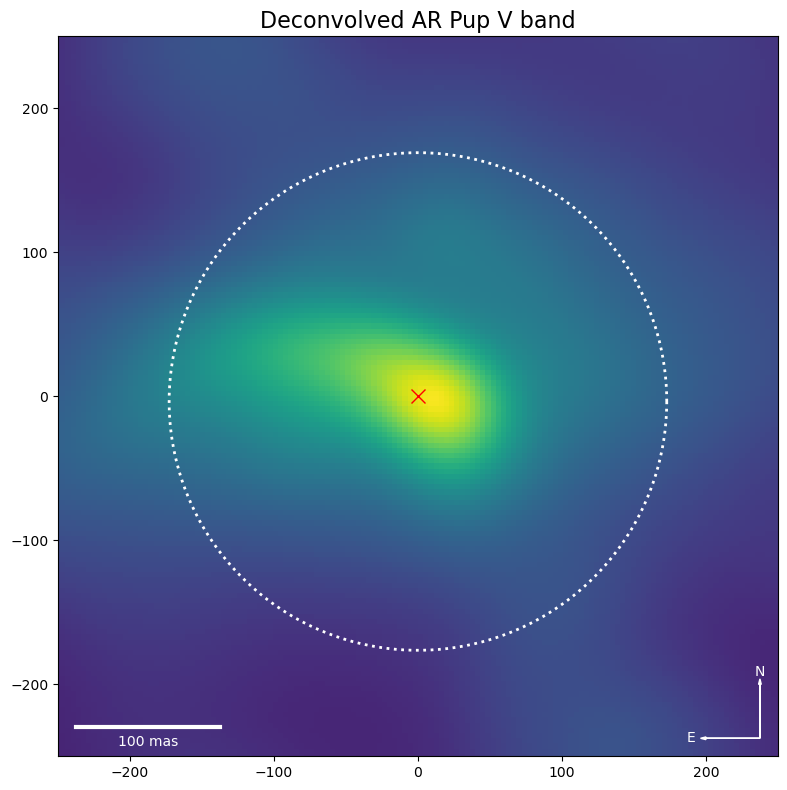

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import find_peaks
from astropy.modeling.models import Gaussian2D
from scipy.optimize import curve_fit
import math

# --- Configuration ---
# You NEED to update these paths and values for your specific data!
fits_file_I_2018 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/deconvolved_I/01.SCI_AR_Pup_I_decon.fits'
fits_file_V_2018 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Deconvolution_corr_tel/ZIMPOL/deconvolved_I/01.SCI_AR_Pup_V_decon.fits' # e.g., 'data/AR_Pup_H_I_meancombined.fits'
output_plot_filename = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_band_azimuthal_profile.png'
output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconvv1/ZIMPOL/azimuthal_circle.png'

plate_scale_mas_per_px = 3.6 # mas/pixel (e.g., for 175 mas = 25 pixels)
separation_pixels = 48     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px # 175 mas
zoom_half_width_mas = 250

# IMPORTANT: You need to provide the correct photometric zero point (ZP) for your data.
# This value depends on your instrument, filter, and how your data is calibrated (e.g., ADU/s to mag).
# Example ZP: A star with 0 mag in this band has 10^ZP counts/s.
# A common reference is that a 0-mag star produces 1 count/s (ZP=0) and then calibrate.
# If your images are already flux-calibrated (e.g., to Jy/pixel), then ZP is different.
# For now, using a placeholder. **Consult your instrument documentation for accurate ZP.**
photometric_zero_point = 23.0 # Placeholder: magnitude zero point (mag/s per ADU/s or count/s)
                               # Adjust this based on your image units and actual ZP.

# --- Helper Functions (similar to what you might have) ---
def load_fits_image(filepath):
    """Loads a FITS image and returns data and header."""
    with fits.open(filepath) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def cart2polar_for_mask_defining(X, Y):
    """Converts Cartesian coordinates to polar (radius, position angle)."""
    r = np.sqrt(X**2 + Y**2)
    # Position angle: 0 at North (Y-axis), increasing East (X-axis).
    # np.arctan2(y, x) gives angle from positive x-axis, increasing counter-clockwise.
    # Convert to astronomical convention: 0 North, increasing East.
    # Adjust for quadrant as np.arctan2 returns -pi to pi.
    pa = np.degrees(np.arctan2(X, Y)) # X for East, Y for North
    pa[pa < 0] += 360 # Ensure 0-360 range
    return r, pa

# --- Main Code ---

try:
    I_data, I_header = load_fits_image(fits_file_I_2018)
    V_data, V_header = load_fits_image(fits_file_V_2018)

    from scipy.ndimage import rotate

    I_data = rotate(I_data, angle=0, reshape=False, order=3)  # order=3 for bicubic interpolation
    V_data = rotate(V_data, angle=0, reshape=False, order=3)

except FileNotFoundError as e:
    print(f"Error: FITS file not found. Please check paths: {e}")
    exit()

# Get image dimensions
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

# Determine image center (peak brightness location)
# A more robust peak finding is often needed for real data.
# For simplicity, assuming the brightest pixel is the star's center.
# Or, if you have (xc, yc) from previous steps, use them directly.
# Here, we'll find the peak in the I image.
coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) > 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
# Use a narrow annulus to sample the profile
annulus_tolerance = 0.5 # pixels, defines the half-width of the annulus

# Mask for the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus
I_data = crop_centered(I_data,194,194)
I_annulus_values = I_data[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# Extract data points within the annulus for V-band using the same mask and sorting
V_data = crop_centered(V_data,194,194)
V_annulus_values = V_data[azimuthal_mask]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
# Formula: mag = -2.5 * log10(Flux / Area) + ZP
# Flux is in ADU/pixel, Area is in arcsec^2 per pixel
# (plate_scale_mas_per_px / 1000)**2 gives area in arcsec^2/pixel
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2

# Avoid log10(0) or log10(negative) by setting a floor
floor_value = 1e-15 # very small positive number
I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + photometric_zero_point
V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + photometric_zero_point # Calculated for V-band

# --- Plotting the Azimuthal Profiles ---

plt.tight_layout()
plt.savefig(output_plot_filename, dpi=300)
plt.show()
plt.close()

fig_profile, ax_profile = plt.subplots(figsize=(10, 6))

ax_profile.plot(pa_sorted, I_surface_brightness, label='Total Intensity (I)', color='blue')
ax_profile.plot(pa_sorted, V_surface_brightness, label='V Band (Total Intensity)', color='red', linestyle='--') # Plot V-band profile


ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak', fontsize=16)
ax_profile.legend(fontsize=12)
ax_profile.grid(True, linestyle=':', alpha=0.7)
ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees

plt.tight_layout()
plt.savefig(output_plot_filename, dpi=300)
plt.show()
plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconvv1/ZIMPOL/i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    zoom_half_width_mas)

# Save overlay image for V band
output_image_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_azimuthal_circle.png'
# output_image_V = output_image_with_circle.replace("v_band", "v_band")
plot_circle_overlay(V_data, 'V', output_image_V,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    zoom_half_width_mas)

V_data2018 = V_data.copy()
I_data2018 = I_data.copy()

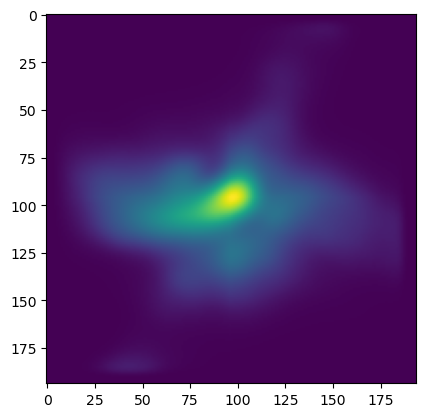

In [198]:
plt.imshow(np.arcsinh(I_data2018))

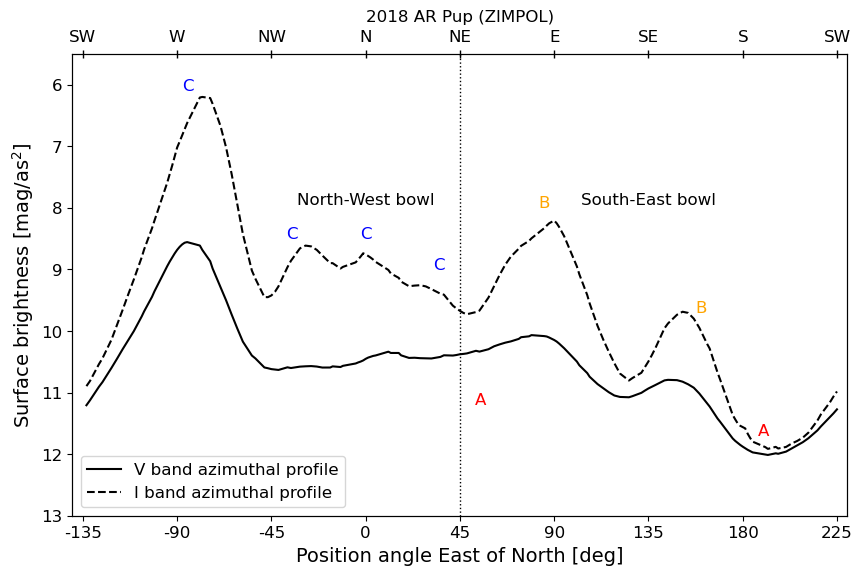

In [194]:
# --- START OF MODIFICATIONS FOR PLOTTING THE AZIMUTHAL PROFILE ---
# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
# Use a narrow annulus to sample the profile
annulus_tolerance = 0.2 # pixels, defines the half-width of the annulus

# Mask for the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus
I_annulus_values = I_data[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile
sort_indices = np.argsort(pa_annulus_values)
pa_sorted_raw = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# Extract data points within the annulus for V-band using the same mask and sorting
V_annulus_values = V_data[azimuthal_mask]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
# Formula: mag = -2.5 * log10(Flux / Area) + ZP
# Flux is in ADU/pixel, Area is in arcsec^2 per pixel
# (plate_scale_mas_per_px / 1000)**2 gives area in arcsec^2/pixel
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2

V_total_flux = np.sum(V_data)
ZP_V = 9.55 + 2.5 * np.log10(V_total_flux)
ZP_V = 25

I_total_flux = np.sum(I_data)
ZP_I = 8.390519 + 2.5 * np.log10(I_total_flux)
ZP_I = 22.31


# Avoid log10(0) or log10(negative) by setting a floor
floor_value = 1e-15 # very small positive number
I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + ZP_I
V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + ZP_V # Calculated for V-band

fig_profile, ax_profile = plt.subplots(figsize=(10, 6))

pa_shifted = np.copy(pa_sorted_raw)
# Shift the entire range so that 0 is in the middle of the plot if desired, or match the plot's range.
# For the left plot's style, 0 is at 'N'. SW is -135.
# This means that PAs between 0 and 225 are directly mapped.
# PAs between 225 and 360 are mapped to negative values (e.g. 270 becomes -90, 315 becomes -45).
pa_shifted[pa_shifted > 225] -= 360

# Sort again after shifting if some points wrapped past each other, just to be safe.
sort_indices_shifted = np.argsort(pa_shifted)
pa_shifted_sorted = pa_shifted[sort_indices_shifted]
I_surface_brightness_sorted_shifted = I_surface_brightness[sort_indices_shifted]
V_surface_brightness_sorted_shifted = V_surface_brightness[sort_indices_shifted]


ax_profile.plot(pa_shifted_sorted, V_surface_brightness_sorted_shifted,
                label='V band azimuthal profile', color='black', linestyle='-') # Solid line for V-band
ax_profile.plot(pa_shifted_sorted, I_surface_brightness_sorted_shifted,
                label='I band azimuthal profile', color='black', linestyle='--') # Dashed line for I-band

ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
ax_profile.set_ylabel(r'Surface brightness [mag/as$^2$]', fontsize=14)

# Set Y-axis limits and invert for magnitude scale
ax_profile.set_ylim(5.5, 13.0) # Adjust these limits to match the desired range
ax_profile.invert_yaxis()     # Invert y-axis for magnitude scale (brighter at top)

# Set X-axis limits
ax_profile.set_xlim(-140, 230) # Slightly wider than -135 to 225 for padding
#
# tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
# tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
# ax_profile.set_xticks(tick_locations)
# ax_profile.set_xticklabels(tick_labels, fontsize=12) # Apply tick labels


# --- Configure the BOTTOM X-axis (Degrees) ---
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
# Define numerical tick locations for the bottom axis
bottom_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(bottom_tick_locations)
ax_profile.set_xticklabels([str(int(loc)) for loc in bottom_tick_locations], fontsize=12) # Display as numbers


# --- Configure the TOP X-axis (Cardinal Directions) ---
ax_top = ax_profile.twiny() # Create a twin x-axis at the top

# Ensure the top axis has the same limits as the bottom axis for alignment
ax_top.set_xlim(ax_profile.get_xlim())

# Define tick locations for the top axis (same as bottom, but with descriptive labels)
top_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
top_tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
ax_top.set_xticks(top_tick_locations)
ax_top.set_xticklabels(top_tick_labels, fontsize=12)
ax_top.set_xlabel('') # No label needed for the top axis itself, as it's part of combined labels
ax_top.tick_params(axis='x', direction='inout', length=6, width=1) # Make ticks visible


# Keep numeric ticks for Y-axis, but adjust font size
ax_profile.tick_params(axis='y', labelsize=12)
# ax_profile.tick_params(axis='x', labelsize=12, bottom=True, top=True, labelbottom=True, labeltop=True) # Apply font size for x-axis numbers too

# Add vertical dotted line at 45 degrees
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)

# Add text labels (A, B, C, North-West/South-East bowl)
# You'll need to eyeball these coordinates based on your actual data peaks
# These are just example positions based on the reference image
ax_profile.text(0, 8, 'North-West bowl', ha='center', va='bottom', fontsize=12) # Adjust Y
ax_profile.text(135, 8, 'South-East bowl', ha='center', va='bottom', fontsize=12) # Adjust Y

ax_profile.text(55, 11, 'A', color='red', ha='center', va='top', fontsize=12) # Center dip
ax_profile.text(190, 11.5, 'A', color='red', ha='center', va='top', fontsize=12) # Edge dip
ax_profile.text(85, 8.5-.7, 'B', color='orange', ha='center', va='top', fontsize=12) # E peak
ax_profile.text(160, 9.5, 'B', color='orange', ha='center', va='top', fontsize=12) # S peak
ax_profile.text(-85, 5.9, 'C', color='blue', ha='center', va='top', fontsize=12) # W dip
ax_profile.text(-35, 9-.7, 'C', color='blue', ha='center', va='top', fontsize=12) # NW dip
ax_profile.text(0, 9-.7, 'C', color='blue', ha='center', va='top', fontsize=12) # N dip
ax_profile.text(35, 9.3-.5, 'C', color='blue', ha='center', va='top', fontsize=12) # N dip

# Add legends
ax_profile.legend(fontsize=12, loc='lower left') # Adjust legend location if needed

ax_profile.grid(False) # The reference image doesn't have a grid
ax_profile.set_facecolor('white') # Explicitly set background to white

# plt.tight_layout()
plt.title('2018 AR Pup (ZIMPOL)')
plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconvv1/ZIMPOL/2018_combined_azimuthal_profile.png', dpi=300)
plt.show()
plt.close(fig_profile)

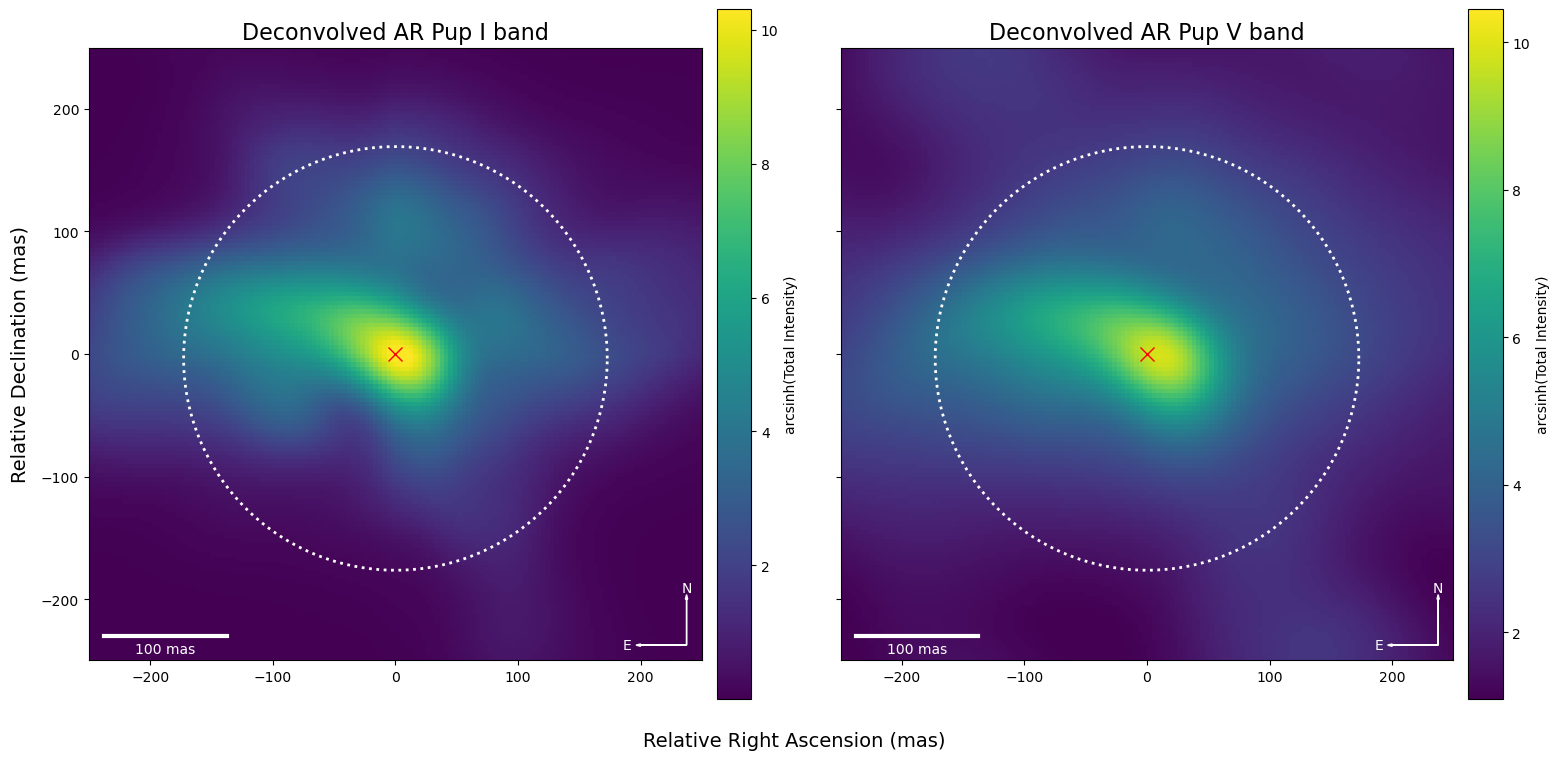

In [183]:
output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/' # Updated output name

# --- Overlaying Dotted Circle, Compass, and Scale Bar on I-band and V-band Images ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) # 1 row, 2 columns

# Define data and titles for looping
plot_data = [
    {'image': I_data2018, 'title': 'Deconvolved AR Pup I band'},
    {'image': V_data2018, 'title': 'Deconvolved AR Pup V band'}
]

# Common zoom range for both plots
zoom_half_width_mas = 250 # Define this for the zoom range

# Loop through each subplot
for i, ax_image in enumerate(axes):
    current_data = plot_data[i]['image']
    current_title = plot_data[i]['title']

    # Apply arcsinh scaling for better visualization
    display_image = np.arcsinh(current_data)

    # Determine display limits for the image (using percentiles for robustness)
    # Filter out non-positive values before percentile to avoid issues with arcsinh(0) or negative
    positive_pixels = display_image[display_image > 0]
    if positive_pixels.size > 0: # Ensure there are positive pixels to calculate percentiles
        vmin_display = np.percentile(positive_pixels, 10)
        vmax_display = np.percentile(positive_pixels, 99.5)
    else: # Fallback if all pixels are zero or negative after arcsinh
        vmin_display = np.min(display_image) if display_image.size > 0 else 0
        vmax_display = np.max(display_image) if display_image.size > 0 else 1


    im = ax_image.imshow(display_image, origin='lower', cmap='viridis',
                         vmin=vmin_display, vmax=vmax_display+2,
                         extent=(-nx/2 * plate_scale_mas_per_px, nx/2 * plate_scale_mas_per_px,
                                 -ny/2 * plate_scale_mas_per_px, ny/2 * plate_scale_mas_per_px))

    # Add a colorbar for each image
    cbar_image = fig.colorbar(im, ax=ax_image, orientation='vertical', pad=0.02)
    cbar_image.set_label('arcsinh(Total Intensity)')

    # Plot the dotted circle (using peak_x and peak_y as the center in pixel coordinates)
    theta_circle = np.linspace(0, 2*np.pi, 360) # 360 points for a smooth circle
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta_circle)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta_circle)

    # Convert pixel coordinates to mas for plotting over the image with mas extent
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale_mas_per_px
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale_mas_per_px

    ax_image.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_mas:.0f} mas circle')
    ax_image.plot(0, 0, 'rx', markersize=10, label='Image Center') # Mark the image center (0,0 mas)

    # Set common zoom limits
    ax_image.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax_image.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)

    ax_image.set_title(current_title, fontsize=16)
    ax_image.grid(False) # Turn off grid for the image

    # --- Add North-East Compass (Bottom-Right, East to the left) ---
    padding_mas = 0.05 * zoom_half_width_mas # 5% of half-width for padding

    compass_base_x = zoom_half_width_mas - padding_mas
    compass_base_y = -zoom_half_width_mas + padding_mas

    arrow_length_mas = 0.15 * zoom_half_width_mas # Length of the N/E arrows
    head_width_mas = 0.05 * arrow_length_mas
    head_length_mas = 0.1 * arrow_length_mas

    # North arrow (points up, along +Y)
    ax_image.arrow(compass_base_x, compass_base_y,
                   0, arrow_length_mas,
                   head_width=head_width_mas, head_length=head_length_mas,
                   fc='white', ec='white', linewidth=1, zorder=10)
    ax_image.text(compass_base_x, compass_base_y + arrow_length_mas + 0.1 * arrow_length_mas,
                  'N', color='white', ha='center', va='bottom', fontsize=10, zorder=10)

    # East arrow (points left, along -X)
    ax_image.arrow(compass_base_x, compass_base_y,
                   -arrow_length_mas, 0, # Note the negative sign for X-direction
                   head_width=head_width_mas, head_length=head_length_mas,
                   fc='white', ec='white', linewidth=1, zorder=10)
    ax_image.text(compass_base_x - arrow_length_mas - 0.2 * arrow_length_mas, compass_base_y,
                  'E', color='white', ha='right', va='center', fontsize=10, zorder=10)


    # --- Add Scale Bar (Bottom-Left) ---
    scale_bar_length_mas = 100  # Desired scale bar length (100 mas)

    padding_mas_x = 0.05 * zoom_half_width_mas
    padding_mas_y = 0.08 * zoom_half_width_mas

    scale_bar_x_start = -zoom_half_width_mas + padding_mas_x
    scale_bar_y = -zoom_half_width_mas + padding_mas_y

    ax_image.plot([scale_bar_x_start, scale_bar_x_start + scale_bar_length_mas],
                  [scale_bar_y, scale_bar_y], 'w-', linewidth=3, zorder=10)

    ax_image.text(scale_bar_x_start + scale_bar_length_mas / 2,
                  scale_bar_y - (0.02 * zoom_half_width_mas),
                  f'{scale_bar_length_mas} mas',
                  color='white', ha='center', va='top', fontsize=10, zorder=10)

# Set common X and Y labels for the entire figure to avoid repetition
fig.text(0.5, 0.01, 'Relative Right Ascension (mas)', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Relative Declination (mas)', va='center', rotation='vertical', fontsize=14)


plt.tight_layout(rect=[0.02, 0.05, 1, 0.95]) # Adjust rect to make space for global labels
plt.savefig(output_image_with_circle+'i_v_subplt_circimg.png', dpi=300)
plt.show()
plt.close(fig)

In [199]:
I2018_undeconvolved = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/Unres+PSFcorr/01.SCI_AR_Pup/01.SCI_AR_Pup_V_I_meancombined.fits')[0].data

(<Figure size 800x600 with 2 Axes>, <Axes: xlabel='mas', ylabel='mas'>)

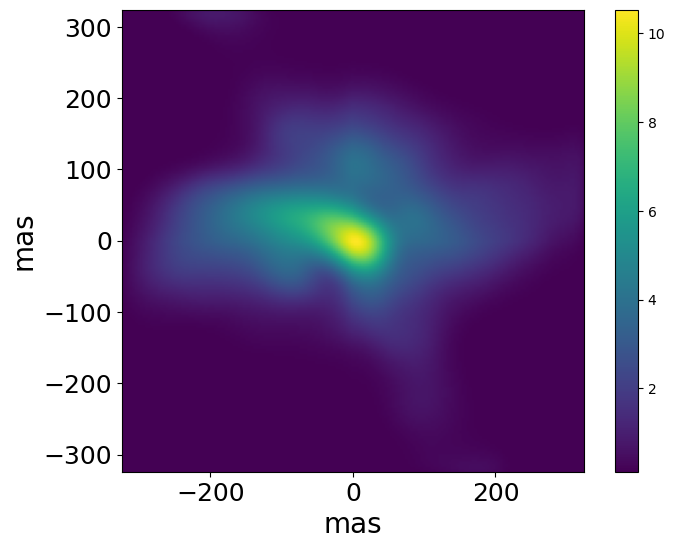

In [215]:
plotImage(I_data2018,90)

### 2016 ZIMP data below:

In [1]:
def plot_circle_overlay(image_data, band_label, output_path, peak_x, peak_y,
                        plate_scale, separation_pixels, zoom_half_width_mas):
    """Plots an image with an azimuthal profile circle and compass + scale bar."""
    ny, nx = image_data.shape
    display_image = np.arcsinh(image_data)

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(display_image, origin='lower', cmap='viridis',
              vmin=0, vmax=9,
              extent=(-nx/2 * plate_scale, nx/2 * plate_scale,
                      -ny/2 * plate_scale, ny/2 * plate_scale))

    # Circle coordinates
    theta = np.linspace(0, 2*np.pi, 360)
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta)
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale

    ax.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_pixels * plate_scale:.0f} mas circle')
    ax.plot(0, 0, 'rx', markersize=10, label='Image Center')

    ax.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)
    ax.set_title(f'Deconvolved AR Pup {band_label} band', fontsize=16)
    ax.grid(False)

    # Compass
    padding = 0.05 * zoom_half_width_mas
    arrow_length = 0.15 * zoom_half_width_mas
    head_width = 0.05 * arrow_length
    head_length = 0.1 * arrow_length
    base_x = zoom_half_width_mas - padding
    base_y = -zoom_half_width_mas + padding

    ax.arrow(base_x, base_y, 0, arrow_length,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x, base_y + arrow_length + 0.1 * arrow_length,
            'N', color='white', ha='center', va='bottom', fontsize=10)

    ax.arrow(base_x, base_y, -arrow_length, 0,
             head_width=head_width, head_length=head_length,
             fc='white', ec='white', linewidth=1, zorder=10)
    ax.text(base_x - arrow_length - 0.2 * arrow_length, base_y,
            'E', color='white', ha='right', va='center', fontsize=10)

    # Scale bar
    scale_length = 100
    pad_x = 0.05 * zoom_half_width_mas
    pad_y = 0.08 * zoom_half_width_mas
    bar_x = -zoom_half_width_mas + pad_x
    bar_y = -zoom_half_width_mas + pad_y

    ax.plot([bar_x, bar_x + scale_length],
            [bar_y, bar_y], 'w-', linewidth=3, zorder=10)
    ax.text(bar_x + scale_length / 2, bar_y - (0.02 * zoom_half_width_mas),
            f'{scale_length} mas',
            color='white', ha='center', va='top', fontsize=10)

    plt.tight_layout()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=300)
    plt.show()
    plt.close(fig)

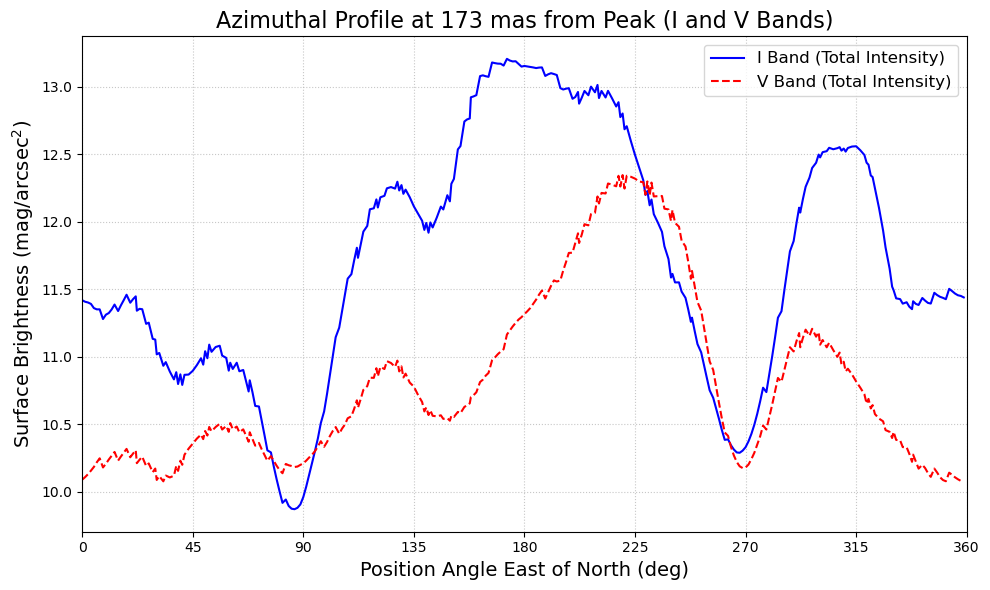

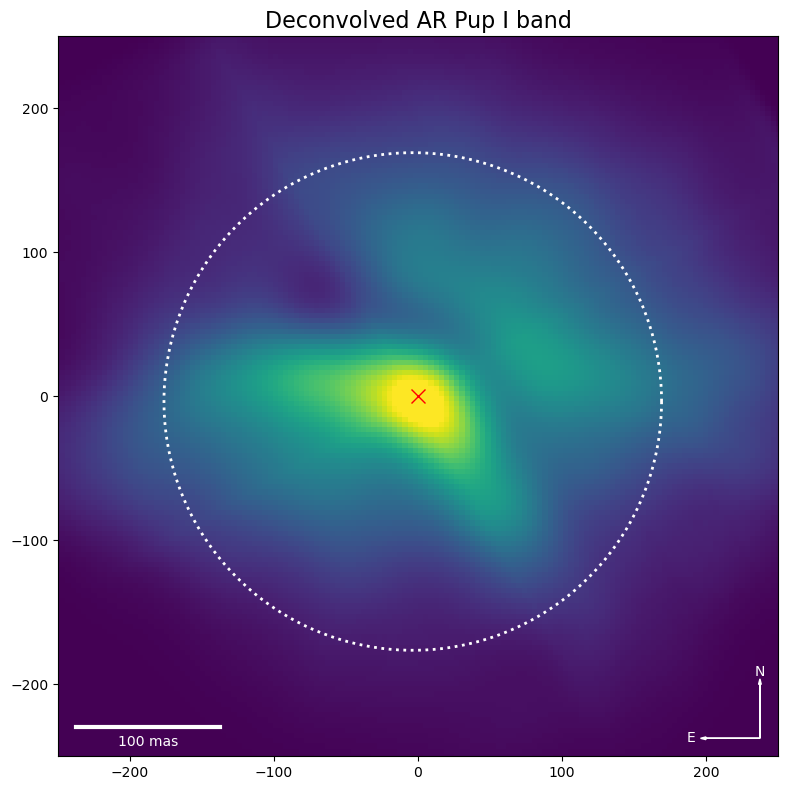

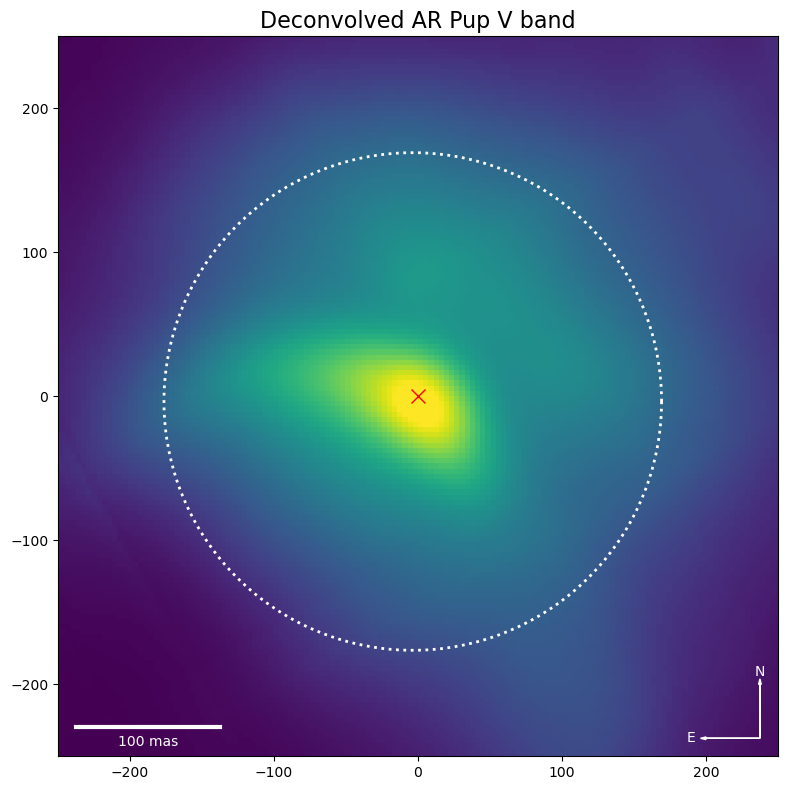

<Figure size 640x480 with 0 Axes>

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import find_peaks
from scipy.ndimage import rotate
import os
# from astropy.modeling.models import Gaussian2D # Not used in current code
# from scipy.optimize import curve_fit # Not used in current code
import math

zoom_half_width_mas = 250

# --- Configuration ---
# You NEED to update these paths and values for your specific data!
fits_file_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOLv2/deconvolved_I/02.SCI_AR_Pup_I_decon.fits'
fits_file_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOL/deconvolved_I/02.SCI_AR_Pup_V_decon.fits'
# ADDED V-BAND FILE
output_plot_filename = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/' # Updated output name
output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/' # Updated output name

plate_scale_mas_per_px = 3.6 # mas/pixel (for SPHERE/ZIMPOL, check your specific data header for exact value)
separation_pixels = 48     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px

# IMPORTANT: You need to provide the correct photometric zero point (ZP) for your data.
# This value depends on your instrument, filter, and how your data is calibrated (e.g., ADU/s to mag).
# I'm assuming the same ZP for I and V band here, but often they are different!
# **Consult your instrument documentation for accurate ZP for each band.**
photometric_zero_point = 25.0 # Placeholder: magnitude zero point

# --- Helper Functions ---
def load_fits_image(filepath):
    """Loads a FITS image and returns data and header."""
    with fits.open(filepath) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def cart2polar_for_mask_defining(X, Y):
    """Converts Cartesian coordinates to polar (radius, position angle)."""
    r = np.sqrt(X**2 + Y**2)
    # Position angle: 0 at North (Y-axis), increasing East (X-axis).
    # np.arctan2(y, x) gives angle from positive x-axis, increasing counter-clockwise.
    # Convert to astronomical convention: 0 North, increasing East.
    # Adjust for quadrant as np.arctan2 returns -pi to pi.
    pa = np.degrees(np.arctan2(X, Y)) # X for East, Y for North
    pa[pa < 0] += 360 # Ensure 0-360 range
    return r, pa

# --- Main Code ---

try:
    I_data, I_header = load_fits_image(fits_file_I)
    V_data, V_header = load_fits_image(fits_file_V) # Load V-band data

    I_data = rotate(I_data, angle=-5, reshape=False, order=3)  # order=3 for bicubic interpolation
    V_data = rotate(V_data, angle=-5, reshape=False, order=3)


except FileNotFoundError as e:
    print(f"Error: FITS file not found. Please check paths: {e}")
    exit()

# Get image dimensions (assuming I and V have same dimensions)
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

# Determine image center (peak brightness location) from I-band image
# For consistency, we use the same peak for both I and V azimuthal profiles.
coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) > 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak in I-band. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
annulus_tolerance = 0.5 # pixels, defines the half-width of the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus for I-band
I_data = crop_centered(I_data,244,244)
I_annulus_values = I_data[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile (same sorting for both I and V)
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# Extract data points within the annulus for V-band using the same mask and sorting
V_data = crop_centered(V_data,244,244)
V_annulus_values = V_data[azimuthal_mask]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
floor_value = 1e-15 # very small positive number to avoid log10(0)

I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + photometric_zero_point
V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + photometric_zero_point # Calculated for V-band


# --- Plotting the Azimuthal Profiles (I and V on the same graph) ---
fig_profile, ax_profile = plt.subplots(figsize=(10, 6))

ax_profile.plot(pa_sorted, I_surface_brightness, label='I Band (Total Intensity)', color='blue')
ax_profile.plot(pa_sorted, V_surface_brightness, label='V Band (Total Intensity)', color='red', linestyle='--') # Plot V-band profile

ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak (I and V Bands)', fontsize=16)
ax_profile.legend(fontsize=12)
ax_profile.grid(True, linestyle=':', alpha=0.7)
ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees

plt.tight_layout()
plt.savefig(output_plot_filename+'2016Zimp_azimuthal_plot.png', dpi=300)
plt.show()
plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    zoom_half_width_mas)

# Save overlay image for V band
output_image_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_azimuthal_circle.png'
# output_image_V = output_image_with_circle.replace("v_band", "v_band")
plot_circle_overlay(V_data, 'V', output_image_V,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    zoom_half_width_mas)

plt.tight_layout()
plt.savefig(output_image_with_circle+'i_v_circimg.png', dpi=300)
plt.show()
plt.close(fig_profile)

I_data2016 = I_data.copy()
V_data2016 = V_data.copy()

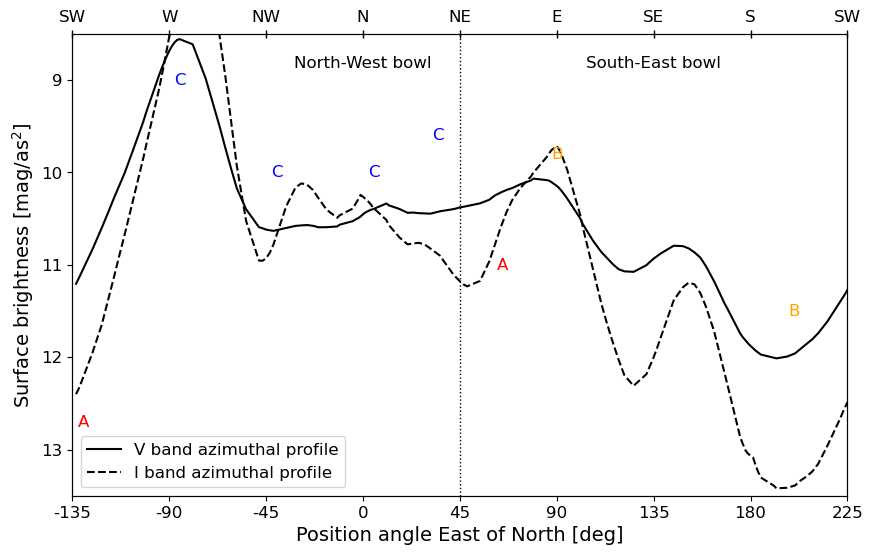

In [185]:
# --- START OF MODIFICATIONS FOR PLOTTING THE AZIMUTHAL PROFILE ---
# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
# Use a narrow annulus to sample the profile
annulus_tolerance = 0.18 # pixels, defines the half-width of the annulus

# Mask for the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# exposure times:
# I_dataog = I_data
# V_dataog = V_data

I_data_cp = I_data/4.0
V_data_cp = V_data/4.0

# Extract data points within the annulus
I_annulus_values = I_data_cp[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile
sort_indices = np.argsort(pa_annulus_values)
pa_sorted_raw = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# Extract data points within the annulus for V-band using the same mask and sorting
V_annulus_values = V_data[azimuthal_mask]
V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
# Formula: mag = -2.5 * log10(Flux / Area) + ZP
# Flux is in ADU/pixel, Area is in arcsec^2 per pixel
# (plate_scale_mas_per_px / 1000)**2 gives area in arcsec^2/pixel

# --- Convert Normalized Flux to Surface Brightness (mag/arcsec^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2


V_total_flux = np.sum(V_data)
ZP_V = 9.5 + 2.5 * np.log10(V_total_flux)
ZP_V = 25.0
# ZP_V = 9.5 + 2.5 * np.log10(V_total_flux) + 23.61

I_total_flux = np.sum(I_data)
ZP_I = 8.590519 + 2.5 * np.log10(I_total_flux)
ZP_I = 22.31
# ZP_I = 8.590519 + 2.5 * np.log10(I_total_flux)


# Avoid log10(0) or log10(negative) by setting a floor
floor_value = 1e-15 # very small positive number
I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + ZP_I
V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + ZP_V # Calculated for V-band

fig_profile, ax_profile = plt.subplots(figsize=(10,6))

pa_shifted = np.copy(pa_sorted_raw)
# Shift the entire range so that 0 is in the middle of the plot if desired, or match the plot's range.
# For the left plot's style, 0 is at 'N'. SW is -135.
# This means that PAs between 0 and 225 are directly mapped.
# PAs between 225 and 360 are mapped to negative values (e.g. 270 becomes -90, 315 becomes -45).
pa_shifted[pa_shifted > 225] -= 360

# Sort again after shifting if some points wrapped past each other, just to be safe.
sort_indices_shifted = np.argsort(pa_shifted)
pa_shifted_sorted = pa_shifted[sort_indices_shifted]
I_surface_brightness_sorted_shifted = I_surface_brightness[sort_indices_shifted]
V_surface_brightness_sorted_shifted = V_surface_brightness[sort_indices_shifted]


ax_profile.plot(pa_shifted_sorted, V_surface_brightness_sorted_shifted,
                label='V band azimuthal profile', color='black', linestyle='-') # Solid line for V-band
ax_profile.plot(pa_shifted_sorted, I_surface_brightness_sorted_shifted,
                label='I band azimuthal profile', color='black', linestyle='--') # Dashed line for I-band

ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
ax_profile.set_ylabel(r'Surface brightness [mag/as$^2$]', fontsize=14)

# Set Y-axis limits and invert for magnitude scale
ax_profile.set_ylim(8.5, 13.5) # Adjust these limits to match the desired range
ax_profile.invert_yaxis()     # Invert y-axis for magnitude scale (brighter at top)

# Set X-axis limits
ax_profile.set_xlim(-135, 225) # Slightly wider than -135 to 225 for padding
#
# tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
# tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
# ax_profile.set_xticks(tick_locations)
# ax_profile.set_xticklabels(tick_labels, fontsize=12) # Apply tick labels


# --- Configure the BOTTOM X-axis (Degrees) ---
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
# Define numerical tick locations for the bottom axis
bottom_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(bottom_tick_locations)
ax_profile.set_xticklabels([str(int(loc)) for loc in bottom_tick_locations], fontsize=12) # Display as numbers


# --- Configure the TOP X-axis (Cardinal Directions) ---
ax_top = ax_profile.twiny() # Create a twin x-axis at the top

# Ensure the top axis has the same limits as the bottom axis for alignment
ax_top.set_xlim(ax_profile.get_xlim())

# Define tick locations for the top axis (same as bottom, but with descriptive labels)
top_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
top_tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
ax_top.set_xticks(top_tick_locations)
ax_top.set_xticklabels(top_tick_labels, fontsize=12)
ax_top.set_xlabel('') # No label needed for the top axis itself, as it's part of combined labels
ax_top.tick_params(axis='x', direction='inout', length=6, width=1) # Make ticks visible


# Keep numeric ticks for Y-axis, but adjust font size
ax_profile.tick_params(axis='y', labelsize=12)
# ax_profile.tick_params(axis='x', labelsize=12, bottom=True, top=True, labelbottom=True, labeltop=True) # Apply font size for x-axis numbers too

# Add vertical dotted line at 45 degrees
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)

# Add text labels (A, B, C, North-West/South-East bowl)
# You'll need to eyeball these coordinates based on your actual data peaks
# These are just example positions based on the reference image
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12) # Adjust Y
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12) # Adjust Y

ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12) # E peak
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12) # S peak
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12) # W dip
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # NW dip
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip

# Add legends
ax_profile.legend(fontsize=12, loc='lower left') # Adjust legend location if needed

ax_profile.grid(False) # The reference image doesn't have a grid
ax_profile.set_facecolor('white') # Explicitly set background to white

# plt.tight_layout()
# plt.title('2016 AR Pup (ZIMPOL)')
plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/2016_combined_azimuthal_profile.png', dpi=300)
plt.show()
plt.close(fig_profile)

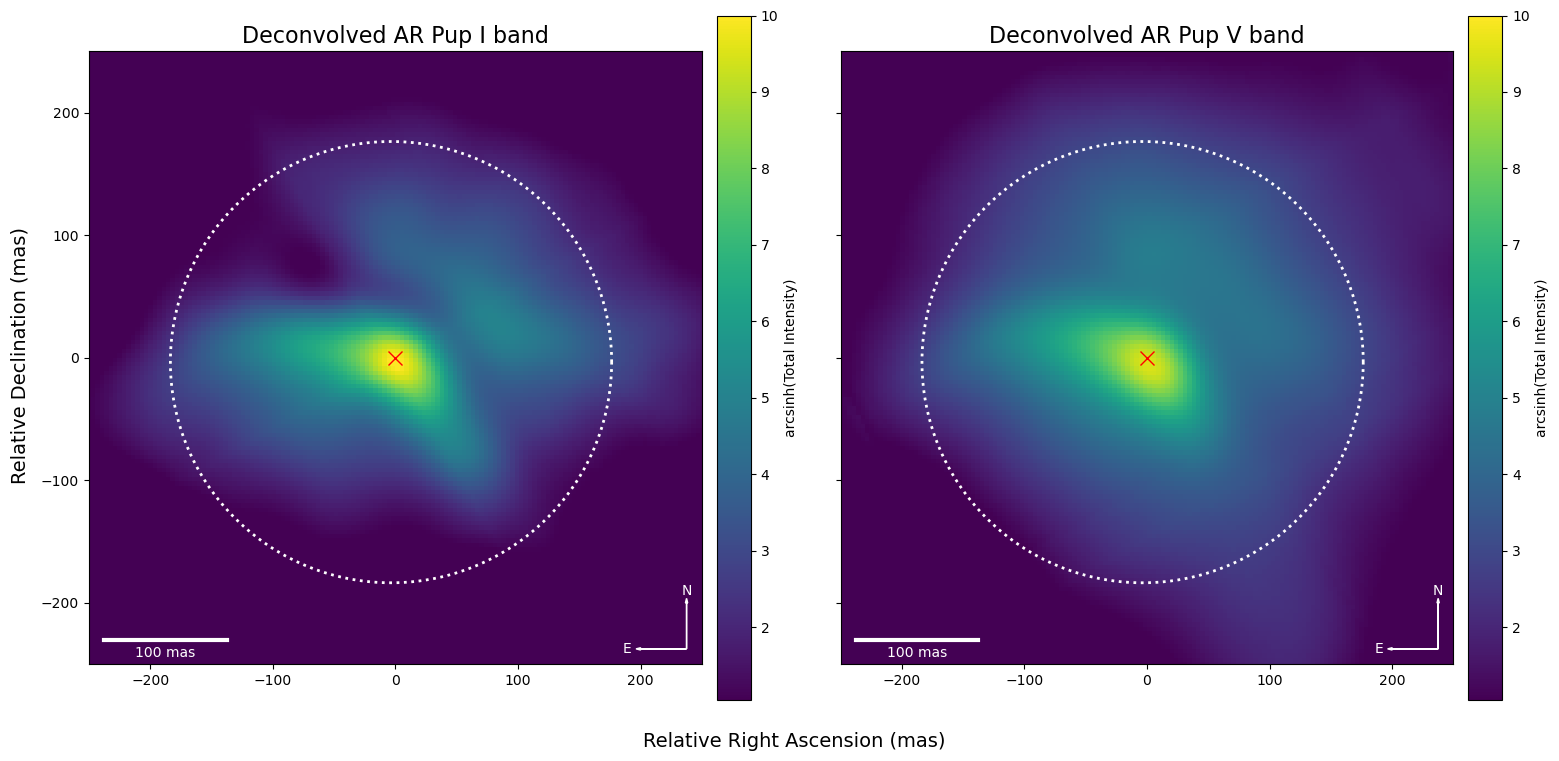

In [94]:
output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconv/ZIMPOL/' # Updated output name

# --- Overlaying Dotted Circle, Compass, and Scale Bar on I-band and V-band Images ---
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True) # 1 row, 2 columns

# Define data and titles for looping
plot_data = [
    {'image': I_data2016, 'title': 'Deconvolved AR Pup I band'},
    {'image': V_data2016, 'title': 'Deconvolved AR Pup V band'}
]

# Common zoom range for both plots
zoom_half_width_mas = 250 # Define this for the zoom range

# Loop through each subplot
for i, ax_image in enumerate(axes):
    current_data = plot_data[i]['image']
    current_title = plot_data[i]['title']

    # Apply arcsinh scaling for better visualization
    display_image = np.arcsinh(current_data)

    # Determine display limits for the image (using percentiles for robustness)
    # Filter out non-positive values before percentile to avoid issues with arcsinh(0) or negative
    positive_pixels = display_image[display_image > 0]
    if positive_pixels.size > 0: # Ensure there are positive pixels to calculate percentiles
        vmin_display = np.percentile(positive_pixels, 10)
        vmax_display = np.percentile(positive_pixels, 99.5)
    else: # Fallback if all pixels are zero or negative after arcsinh
        vmin_display = np.min(display_image) if display_image.size > 0 else 0
        vmax_display = np.max(display_image) if display_image.size > 0 else 1


    im = ax_image.imshow(display_image, origin='lower', cmap='viridis',
                         vmin=1.05, vmax=10,
                         extent=(-nx/2 * plate_scale_mas_per_px, nx/2 * plate_scale_mas_per_px,
                                 -ny/2 * plate_scale_mas_per_px, ny/2 * plate_scale_mas_per_px))

    # Add a colorbar for each image
    cbar_image = fig.colorbar(im, ax=ax_image, orientation='vertical', pad=0.02)
    cbar_image.set_label('arcsinh(Total Intensity)')

    # Plot the dotted circle (using peak_x and peak_y as the center in pixel coordinates)
    theta_circle = np.linspace(0, 2*np.pi, 360) # 360 points for a smooth circle
    circle_x_pixels = peak_x + separation_pixels * np.cos(theta_circle)
    circle_y_pixels = peak_y + separation_pixels * np.sin(theta_circle)

    # Convert pixel coordinates to mas for plotting over the image with mas extent
    circle_x_mas = (circle_x_pixels - nx/2) * plate_scale_mas_per_px
    circle_y_mas = (circle_y_pixels - ny/2) * plate_scale_mas_per_px

    ax_image.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_mas:.0f} mas circle')
    ax_image.plot(0, 0, 'rx', markersize=10, label='Image Center') # Mark the image center (0,0 mas)

    # Set common zoom limits
    ax_image.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
    ax_image.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)

    ax_image.set_title(current_title, fontsize=16)
    ax_image.grid(False) # Turn off grid for the image

    # --- Add North-East Compass (Bottom-Right, East to the left) ---
    padding_mas = 0.05 * zoom_half_width_mas # 5% of half-width for padding

    compass_base_x = zoom_half_width_mas - padding_mas
    compass_base_y = -zoom_half_width_mas + padding_mas

    arrow_length_mas = 0.15 * zoom_half_width_mas # Length of the N/E arrows
    head_width_mas = 0.05 * arrow_length_mas
    head_length_mas = 0.1 * arrow_length_mas

    # North arrow (points up, along +Y)
    ax_image.arrow(compass_base_x, compass_base_y,
                   0, arrow_length_mas,
                   head_width=head_width_mas, head_length=head_length_mas,
                   fc='white', ec='white', linewidth=1, zorder=10)
    ax_image.text(compass_base_x, compass_base_y + arrow_length_mas + 0.1 * arrow_length_mas,
                  'N', color='white', ha='center', va='bottom', fontsize=10, zorder=10)

    # East arrow (points left, along -X)
    ax_image.arrow(compass_base_x, compass_base_y,
                   -arrow_length_mas, 0, # Note the negative sign for X-direction
                   head_width=head_width_mas, head_length=head_length_mas,
                   fc='white', ec='white', linewidth=1, zorder=10)
    ax_image.text(compass_base_x - arrow_length_mas - 0.2 * arrow_length_mas, compass_base_y,
                  'E', color='white', ha='right', va='center', fontsize=10, zorder=10)


    # --- Add Scale Bar (Bottom-Left) ---
    scale_bar_length_mas = 100  # Desired scale bar length (100 mas)

    padding_mas_x = 0.05 * zoom_half_width_mas
    padding_mas_y = 0.08 * zoom_half_width_mas

    scale_bar_x_start = -zoom_half_width_mas + padding_mas_x
    scale_bar_y = -zoom_half_width_mas + padding_mas_y

    ax_image.plot([scale_bar_x_start, scale_bar_x_start + scale_bar_length_mas],
                  [scale_bar_y, scale_bar_y], 'w-', linewidth=3, zorder=10)

    ax_image.text(scale_bar_x_start + scale_bar_length_mas / 2,
                  scale_bar_y - (0.02 * zoom_half_width_mas),
                  f'{scale_bar_length_mas} mas',
                  color='white', ha='center', va='top', fontsize=10, zorder=10)

# Set common X and Y labels for the entire figure to avoid repetition
fig.text(0.5, 0.01, 'Relative Right Ascension (mas)', ha='center', fontsize=14)
fig.text(0.01, 0.5, 'Relative Declination (mas)', va='center', rotation='vertical', fontsize=14)


plt.tight_layout(rect=[0.02, 0.05, 1, 0.95]) # Adjust rect to make space for global labels
plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconv/ZIMPOL/2016_ZIMP_i_v_subplt_circimg.png', dpi=300)
plt.show()
plt.close(fig)

In [191]:
output_image_with_circle

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconv/ZIMPOL/'

In [31]:
# #fitting ellipse to rings
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.transforms import offset_copy
# from astropy.io import fits
# import os, fnmatch
# import matplotlib.gridspec as gridspec
# from scipy import optimize
# from skimage.measure import EllipseModel
# from scipy import interpolate
# from textwrap import wrap
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import math
# from skimage.measure import profile_line
# import matplotlib.patches as patches
# from scipy.optimize import curve_fit
#
# starnames = {'HD75885':'HD75885','AR_Pup_dc_notnorm':'AR Pup','HR4049_combined':'HR4049','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}
# fittype='PI'
# annulus='I'
#
# savefig='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'AR_Pup_ellipse/'
# try:
#  # Create target Directory
#    os.mkdir(savefig)
# except FileExistsError:
#     print()
# lim=100
#
# PI_I, n=Loadimages_notdeconv(star,'PI',dirdat,'I','_meancombined')
# PI_V, n=Loadimages_notdeconv(star,'PI',dirdat,'V','_meancombined')
# Q_phi_I, n=Loadimages_notdeconv(star,'Q_phi',dirdat,'I','_meancombined')
# Q_phi_V, n=Loadimages_notdeconv(star,'Q_phi',dirdat,'V','_meancombined')
#
# dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'Deconvolution_corr_tel/'+star+'/'
# dir =dirdat +'/deconvolved_'+'I'+'/'
# I_I, R, x, y, d_in,X,Y= LoadImage_dec(dir,'I')
# I_V, R, x, y, d_in,X,Y= LoadImage_dec(dir,'V')
# dir =dirdat +'/deconvolved_'+'PI'+'/'
# PI_dec_I, R, x, y, d_in,X,Y= LoadImage_dec(dir,'I')
# PI_dec_V, R, x, y, d_in,X,Y= LoadImage_dec(dir,'V')
#
#
# xr = np.linspace(0, n, num=n)
# yr = np.linspace(0, n, num=n)
# xr = xr-xc
# yr = yr-yc
# Xr, Yr = np.meshgrid(xr, yr)
# R=np.sqrt(Xr**2 + (Yr)**2)



02.SCI_AR_Pup_I_PI_meancombined.fits


UnboundLocalError: cannot access local variable 'n' where it is not associated with a value

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_circle_overlay(image_data, band, output_filename, peak_x, peak_y, plate_scale, radius_pixels, zoom_half_width_mas):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the image
    im = ax.imshow(image_data, origin='lower', cmap='gray', vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 99))

    # Draw the annulus at the specified radius
    theta = np.linspace(0, 2*np.pi, 360)
    x_circle = peak_x + radius_pixels * np.cos(theta)
    y_circle = peak_y + radius_pixels * np.sin(theta)
    ax.plot(x_circle, y_circle, color='red', linestyle='--', linewidth=1.2, label='25 pixel annulus')

    # Add PA labels every 45°
    for angle_deg in np.arange(0, 360, 45):
        angle_rad = np.deg2rad(angle_deg)
        x_label = peak_x + (radius_pixels + 6) * np.sin(angle_rad)  # X = East
        y_label = peak_y + (radius_pixels + 6) * np.cos(angle_rad)  # Y = North
        ax.text(x_label, y_label, f'{angle_deg}°', ha='center', va='center', fontsize=10, color='yellow', weight='bold')

    # Annotate center
    ax.plot(peak_x, peak_y, marker='x', color='cyan', label='Image Peak')

    # Set zoom window (in mas → convert to pixels)
    zoom_pixels = zoom_half_width_mas / plate_scale
    ax.set_xlim(peak_x - zoom_pixels, peak_x + zoom_pixels)
    ax.set_ylim(peak_y - zoom_pixels, peak_y + zoom_pixels)

    ax.set_title(f'{band}-band with Azimuthal Annulus', fontsize=14)
    ax.set_xlabel('X [pixels]')
    ax.set_ylabel('Y [pixels]')
    ax.legend(fontsize=10, loc='upper right')
    ax.set_aspect('equal')
    plt.tight_layout()

    # Save figure
    plt.savefig(output_filename, dpi=300)
    plt.close(fig)


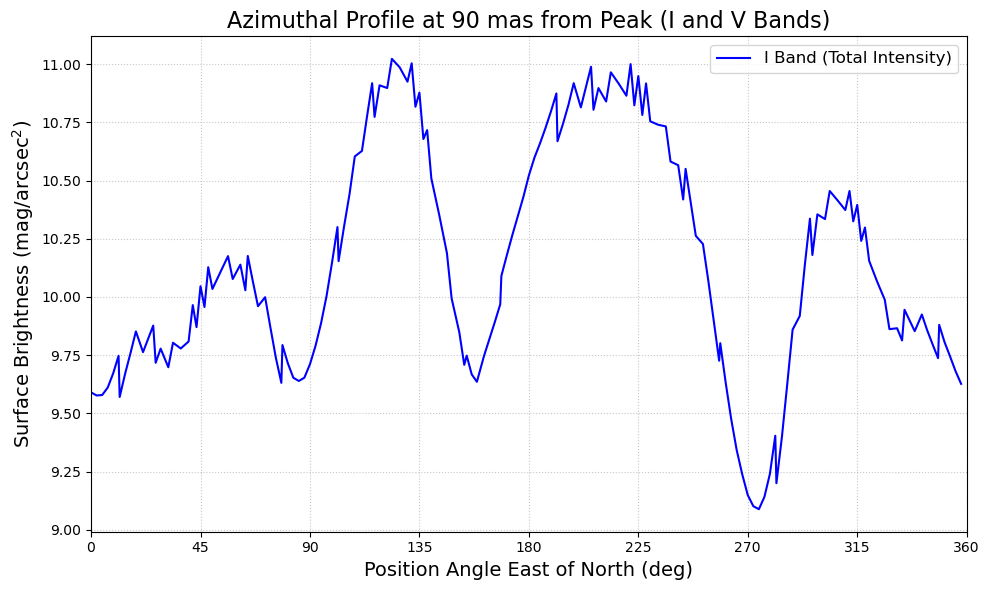

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from photutils.detection import find_peaks
from scipy.ndimage import rotate
import os
# from astropy.modeling.models import Gaussian2D # Not used in current code
# from scipy.optimize import curve_fit # Not used in current code
import math

zoom_half_width_mas = 250

# --- Configuration ---
# You NEED to update these paths and values for your specific data!
fits_file_I = '/Users/aksitadeo/PycharmProjects/Ertel/MQ data/PAGB/PAGB_CODES/PAGB_CODES/AR_Pup_DK_Ertel/AR_Pup_old/files_julien/ZIMPOL_decon.fits'
# fits_file_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/ZIMPOL/deconvolved_I/02.SCI_AR_Pup_V_decon.fits'
# ADDED V-BAND FILE
# output_plot_filename = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/' # Updated output name
# output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/' # Updated output name

plate_scale_mas_per_px = 3.6 # mas/pixel (for SPHERE/ZIMPOL, check your specific data header for exact value)
separation_pixels = 25     # Distance from peak for azimuthal profile
separation_mas = separation_pixels * plate_scale_mas_per_px

# IMPORTANT: You need to provide the correct photometric zero point (ZP) for your data.
# This value depends on your instrument, filter, and how your data is calibrated (e.g., ADU/s to mag).
# I'm assuming the same ZP for I and V band here, but often they are different!
# **Consult your instrument documentation for accurate ZP for each band.**
photometric_zero_point = 25.0 # Placeholder: magnitude zero point

# --- Helper Functions ---
def load_fits_image(filepath):
    """Loads a FITS image and returns data and header."""
    with fits.open(filepath) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    return data, header

def cart2polar_for_mask_defining(X, Y):
    """Converts Cartesian coordinates to polar (radius, position angle)."""
    r = np.sqrt(X**2 + Y**2)
    # Position angle: 0 at North (Y-axis), increasing East (X-axis).
    # np.arctan2(y, x) gives angle from positive x-axis, increasing counter-clockwise.
    # Convert to astronomical convention: 0 North, increasing East.
    # Adjust for quadrant as np.arctan2 returns -pi to pi.
    pa = np.degrees(np.arctan2(X, Y)) # X for East, Y for North
    pa[pa < 0] += 360 # Ensure 0-360 range
    return r, pa

# --- Main Code ---

try:
    I_data, I_header = load_fits_image(fits_file_I)
    # V_data, V_header = load_fits_image(fits_file_V) # Load V-band data

    I_data = rotate(I_data, angle=0, reshape=False, order=3)  # order=3 for bicubic interpolation
    # V_data = rotate(V_data, angle=0, reshape=False, order=3)


except FileNotFoundError as e:
    print(f"Error: FITS file not found. Please check paths: {e}")
    exit()

# Get image dimensions (assuming I and V have same dimensions)
ny, nx = I_data.shape
if ny != nx:
    print("Warning: Image is not square. Code assumes square images.")

# Determine image center (peak brightness location) from I-band image
# For consistency, we use the same peak for both I and V azimuthal profiles.
coords = find_peaks(I_data, np.max(I_data)*0.5, npeaks=1) # find_peaks threshold needs adjusting
if len(coords) < 0:
    peak_y, peak_x = int(coords['y_peak'][0]), int(coords['x_peak'][0])
else:
    print("Warning: Could not find a clear peak in I-band. Assuming image center for now.")
    peak_y, peak_x = ny // 2, nx // 2

# Create coordinate grids centered on the peak
x_coords = np.arange(nx) - peak_x
y_coords = np.arange(ny) - peak_y
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Convert to polar coordinates relative to the peak
radii, position_angles = cart2polar_for_mask_defining(X_grid, Y_grid)

# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
annulus_tolerance = 0.5 # pixels, defines the half-width of the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus for I-band
# I_data = crop_centered(I_data,244,244)
I_annulus_values = I_data[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle to get a coherent profile (same sorting for both I and V)
sort_indices = np.argsort(pa_annulus_values)
pa_sorted = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# Extract data points within the annulus for V-band using the same mask and sorting
# V_data = crop_centered(V_data,244,244)
# V_annulus_values = V_data[azimuthal_mask]
# V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
floor_value = 1e-15 # very small positive number to avoid log10(0)

I_surface_brightness = -2.5 * np.log10(I_sorted/pixel_area_arcsec2) + photometric_zero_point
# V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + photometric_zero_point # Calculated for V-band


# --- Plotting the Azimuthal Profiles (I and V on the same graph) ---
fig_profile, ax_profile = plt.subplots(figsize=(10, 6))

ax_profile.plot(pa_sorted, I_surface_brightness, label='I Band (Total Intensity)', color='blue')
# ax_profile.plot(pa_sorted, V_surface_brightness, label='V Band (Total Intensity)', color='red', linestyle='--') # Plot V-band profile

ax_profile.set_xlabel('Position Angle East of North (deg)', fontsize=14)
ax_profile.set_ylabel(r'Surface Brightness (mag/arcsec$^2$)', fontsize=14)
ax_profile.set_title(f'Azimuthal Profile at {separation_mas:.0f} mas from Peak (I and V Bands)', fontsize=16)
ax_profile.legend(fontsize=12)
ax_profile.grid(True, linestyle=':', alpha=0.7)
ax_profile.set_xlim(0, 360) # Ensure full 0-360 range
ax_profile.set_xticks(np.arange(0, 361, 45)) # Ticks every 45 degrees

plt.tight_layout()
# plt.savefig(output_plot_filename+'2016Zimp_azimuthal_plot.png', dpi=300)
plt.show()
plt.close(fig_profile)

# Save overlay image for I band
output_image_I = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/i_azimuthal_circle.png'
# output_image_I = output_image_with_circle.replace("v_band", "i_band")
plot_circle_overlay(I_data, 'I', output_image_I,
                    peak_x, peak_y,
                    plate_scale_mas_per_px,
                    separation_pixels,
                    zoom_half_width_mas)

# # Save overlay image for V band
# output_image_V = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv1/ZIMPOL/v_azimuthal_circle.png'
# # output_image_V = output_image_with_circle.replace("v_band", "v_band")
# plot_circle_overlay(V_data, 'V', output_image_V,
#                     peak_x, peak_y,
#                     plate_scale_mas_per_px,
#                     separation_pixels,
#                     zoom_half_width_mas)
#
# plt.tight_layout()
# # plt.savefig(output_image_with_circle+'i_v_circimg.png', dpi=300)
plt.show()
# plt.close(fig_profile)

# I_data2016 = I_data.copy()
# V_data2016 = V_data.copy()

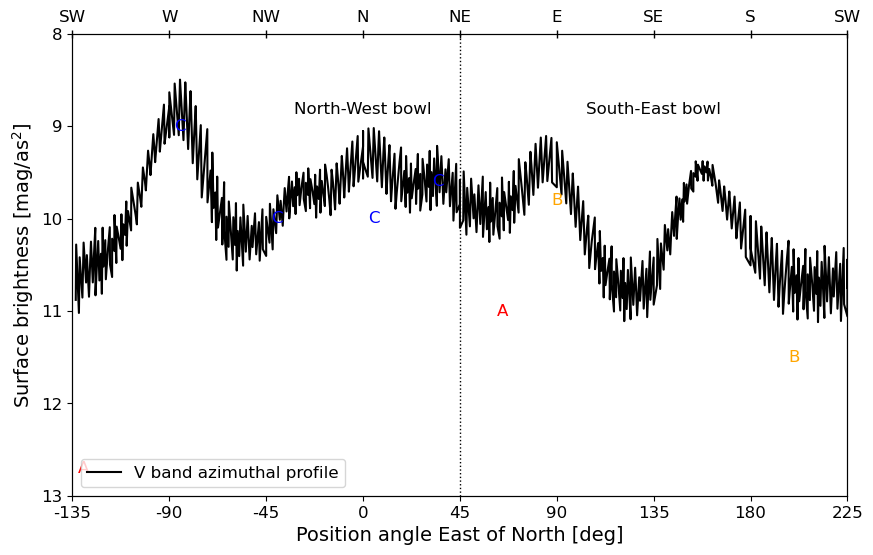

In [11]:
# --- START OF MODIFICATIONS FOR PLOTTING THE AZIMUTHAL PROFILE ---
# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
# Use a narrow annulus to sample the profile
annulus_tolerance = 2 # pixels, defines the half-width of the annulus

# Mask for the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# exposure times:
# I_dataog = I_data
# V_dataog = V_data

I_data_cp = I_data.copy()
# V_data_cp = V_data/4.0

# Extract data points within the annulus
I_annulus_values = I_data_cp[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# mean_I_flux = np.mean(I_annulus_values)

# Sort by position angle to get a coherent profile
sort_indices = np.argsort(pa_annulus_values)
pa_sorted_raw = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]


# Extract data points within the annulus for V-band using the same mask and sorting
# V_annulus_values = V_data[azimuthal_mask]
# V_sorted = V_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
# Formula: mag = -2.5 * log10(Flux / Area) + ZP
# Flux is in ADU/pixel, Area is in arcsec^2 per pixel
# (plate_scale_mas_per_px / 1000)**2 gives area in arcsec^2/pixel

# --- Convert Normalized Flux to Surface Brightness (mag/arcsec^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2

#
# V_total_flux = np.sum(V_data)
# ZP_V = 9.5 + 2.5 * np.log10(V_total_flux)
# ZP_V = 25.0
# ZP_V = 9.5 + 2.5 * np.log10(V_total_flux) + 23.61

I_total_flux = np.sum(I_data)
ZP_I = 8.590519 + 2.5 * np.log10(I_total_flux)
ZP_I = 24.8
# ZP_I = 22.31
# ZP_I = 8.590519 + 2.5 * np.log10(I_total_flux)


# Avoid log10(0) or log10(negative) by setting a floor
floor_value = 1e-15 # very small positive number
I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + ZP_I
# V_surface_brightness = -2.5 * np.log10(np.maximum(V_sorted, floor_value) / pixel_area_arcsec2) + ZP_V # Calculated for V-band

fig_profile, ax_profile = plt.subplots(figsize=(10,6))

pa_shifted = np.copy(pa_sorted_raw)
# Shift the entire range so that 0 is in the middle of the plot if desired, or match the plot's range.
# For the left plot's style, 0 is at 'N'. SW is -135.
# This means that PAs between 0 and 225 are directly mapped.
# PAs between 225 and 360 are mapped to negative values (e.g. 270 becomes -90, 315 becomes -45).
pa_shifted[pa_shifted > 225] -= 360

# Sort again after shifting if some points wrapped past each other, just to be safe.
sort_indices_shifted = np.argsort(pa_shifted)
pa_shifted_sorted = pa_shifted[sort_indices_shifted]
I_surface_brightness_sorted_shifted = I_surface_brightness[sort_indices_shifted]
# V_surface_brightness_sorted_shifted = V_surface_brightness[sort_indices_shifted]


# ax_profile.plot(pa_shifted_sorted, V_surface_brightness_sorted_shifted,
#                 label='V band azimuthal profile', color='black', linestyle='-') # Solid line for V-band
ax_profile.plot(pa_shifted_sorted, I_surface_brightness_sorted_shifted,
                label='V band azimuthal profile', color='black', linestyle='-') # Dashed line for I-band

ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
ax_profile.set_ylabel(r'Surface brightness [mag/as$^2$]', fontsize=14)

# Set Y-axis limits and invert for magnitude scale
ax_profile.set_ylim(8, 13) # Adjust these limits to match the desired range
ax_profile.invert_yaxis()     # Invert y-axis for magnitude scale (brighter at top)

# Set X-axis limits
ax_profile.set_xlim(-135, 225) # Slightly wider than -135 to 225 for padding
#
# tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
# tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
# ax_profile.set_xticks(tick_locations)
# ax_profile.set_xticklabels(tick_labels, fontsize=12) # Apply tick labels


# --- Configure the BOTTOM X-axis (Degrees) ---
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
# Define numerical tick locations for the bottom axis
bottom_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(bottom_tick_locations)
ax_profile.set_xticklabels([str(int(loc)) for loc in bottom_tick_locations], fontsize=12) # Display as numbers


# --- Configure the TOP X-axis (Cardinal Directions) ---
ax_top = ax_profile.twiny() # Create a twin x-axis at the top

# Ensure the top axis has the same limits as the bottom axis for alignment
ax_top.set_xlim(ax_profile.get_xlim())

# Define tick locations for the top axis (same as bottom, but with descriptive labels)
top_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
top_tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
ax_top.set_xticks(top_tick_locations)
ax_top.set_xticklabels(top_tick_labels, fontsize=12)
ax_top.set_xlabel('') # No label needed for the top axis itself, as it's part of combined labels
ax_top.tick_params(axis='x', direction='inout', length=6, width=1) # Make ticks visible


# Keep numeric ticks for Y-axis, but adjust font size
ax_profile.tick_params(axis='y', labelsize=12)
# ax_profile.tick_params(axis='x', labelsize=12, bottom=True, top=True, labelbottom=True, labeltop=True) # Apply font size for x-axis numbers too

# Add vertical dotted line at 45 degrees
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)

# Add text labels (A, B, C, North-West/South-East bowl)
# You'll need to eyeball these coordinates based on your actual data peaks
# These are just example positions based on the reference image
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12) # Adjust Y
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12) # Adjust Y

ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12) # E peak
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12) # S peak
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12) # W dip
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # NW dip
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip

# Add legends
ax_profile.legend(fontsize=12, loc='lower left') # Adjust legend location if needed

ax_profile.grid(False) # The reference image doesn't have a grid
ax_profile.set_facecolor('white') # Explicitly set background to white

# plt.tight_layout()
# plt.title('2016 AR Pup (ZIMPOL)')
# plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/After_deconv/ZIMPOL/2016_combined_azimuthal_profile.png', dpi=300)
plt.show()
# plt.close(fig_profile)

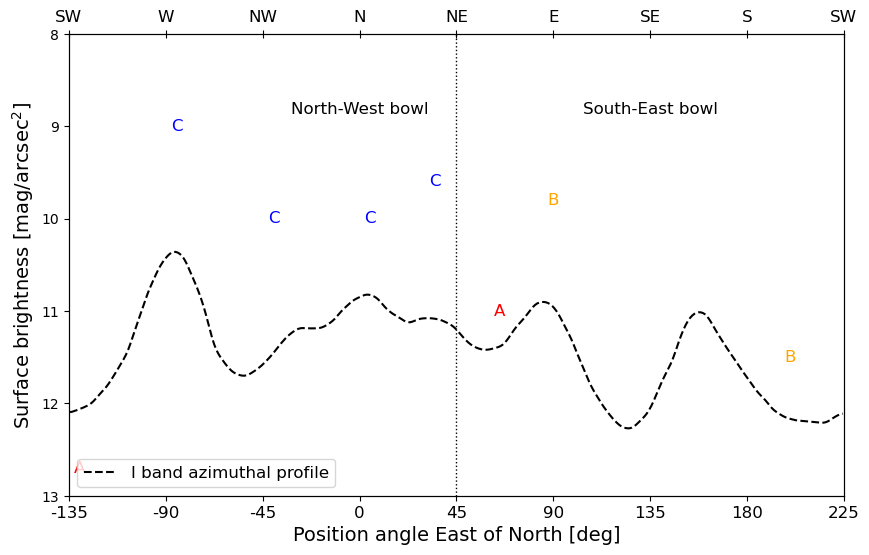

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# --- Parameters ---
annulus_tolerance = 1
target_radius = 25
n_neighbors = 8
bin_width = 1.0
plate_scale_mas_per_px = 3.6
floor_value = 1e-15
smooth_sigma = 2  # in bins

# --- Step 1: Mask annulus and get coordinates ---
annulus_mask = (radii >= target_radius - annulus_tolerance) & (radii <= target_radius + annulus_tolerance)
y_idx, x_idx = np.where(annulus_mask)
coords = np.vstack((x_idx, y_idx)).T

# Get flux and position angle
I_data_cp = I_data / 4.0
flux_values = I_data_cp[annulus_mask]
pa_values = position_angles[annulus_mask]

# --- Step 2: Nearest neighbor smoothing ---
tree = cKDTree(coords)
_, neighbor_indices = tree.query(coords, k=n_neighbors)
smoothed_flux = np.array([np.mean(flux_values[inds]) for inds in neighbor_indices])

# --- Step 3: Shift PAs ---
pa_shifted = np.copy(pa_values)
pa_shifted[pa_shifted > 225] -= 360

# --- Step 4: Bin by PA ---
bins = np.arange(-135, 225 + bin_width, bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2
mean_flux_per_bin = np.full_like(bin_centers, np.nan, dtype=np.float64)

for i in range(len(bins) - 1):
    mask = (pa_shifted >= bins[i]) & (pa_shifted < bins[i + 1])
    if np.any(mask):
        mean_flux_per_bin[i] = np.mean(smoothed_flux[mask])

# --- Step 5: Interpolate missing values (NaNs) ---
valid = ~np.isnan(mean_flux_per_bin)
interp_func = interp1d(bin_centers[valid], mean_flux_per_bin[valid], kind='linear', fill_value='extrapolate')
mean_flux_interp = interp_func(bin_centers)

# --- Step 6: Optional smoothing ---
mean_flux_smooth = gaussian_filter1d(mean_flux_interp, sigma=smooth_sigma)

# --- Step 7: Convert to surface brightness ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0) ** 2
ZP_I = 24.8
I_sb_profile = -2.5 * np.log10(np.maximum(mean_flux_smooth, floor_value) / pixel_area_arcsec2) + ZP_I

# --- Step 8: Plot ---
fig, ax_profile = plt.subplots(figsize=(10, 6))
ax_profile.plot(bin_centers, I_sb_profile, color='black', linestyle='--', label='I band azimuthal profile')

# Axes setup
ax_profile.set_ylabel(r'Surface brightness [mag/arcsec$^2$]', fontsize=14)
ax_profile.set_ylim(8, 13)
ax_profile.invert_yaxis()
ax_profile.set_xlim(-135, 225)
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
tick_pos = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(tick_pos)
ax_profile.set_xticklabels([str(p) for p in tick_pos], fontsize=12)

# Cardinal direction top axis
ax_top = ax_profile.twiny()
ax_top.set_xlim(ax_profile.get_xlim())
ax_top.set_xticks(tick_pos)
ax_top.set_xticklabels(['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW'], fontsize=12)
ax_top.set_xlabel('')
ax_top.tick_params(axis='x', direction='inout', length=6)

# Optional annotations
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12)
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12)

# Feature labels
ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12)
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12)
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12)
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12)

ax_profile.legend(fontsize=12, loc='lower left')
ax_profile.grid(False)
ax_profile.set_facecolor('white')

plt.show()


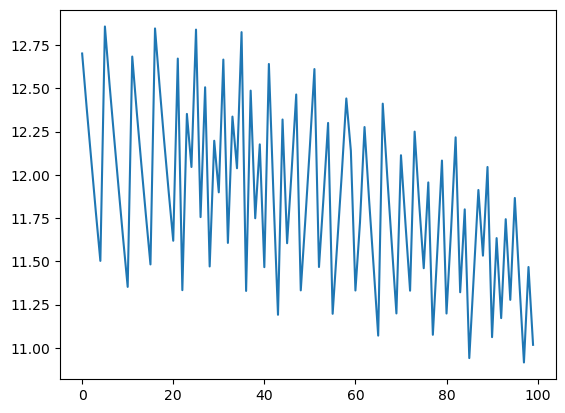

In [283]:
plt.plot(I_surface_brightness_sorted_shifted[0:100])

In [274]:
print(len(I_sorted))
print(len(I_annulus_values))

1248
1248
201


In [266]:
I_annulus_values

array([0.71456349, 0.76539337, 0.82210482, ..., 2.43082198, 2.28376121,
       2.17564781], shape=(1248,))

In [ ]:
# --- START OF MODIFICATIONS FOR PLOTTING THE AZIMUTHAL PROFILE ---
# --- Extract Azimuthal Profiles ---
# Find pixels that are within a small radial tolerance around the desired separation
# Use a narrow annulus to sample the profile
separation_pixels = 25
annulus_tolerance = 0.18

# Mask for the annulus
azimuthal_mask = (radii >= separation_pixels - annulus_tolerance) & \
                 (radii < separation_pixels + annulus_tolerance)

# Extract data points within the annulus
I_annulus_values = I_data_cp[azimuthal_mask]
pa_annulus_values = position_angles[azimuthal_mask]

# Sort by position angle
sort_indices = np.argsort(pa_annulus_values)
pa_sorted_raw = pa_annulus_values[sort_indices]
I_sorted = I_annulus_values[sort_indices]

# --- Convert to Surface Brightness (Magnitude/as^2) ---
# Formula: mag = -2.5 * log10(Flux / Area) + ZP
# Area is in arcsec^2 per pixel
# (plate_scale_mas_per_px / 1000)**2 gives area in arcsec^2/pixel

# --- Convert Normalized Flux to Surface Brightness (mag/arcsec^2) ---
pixel_area_arcsec2 = (plate_scale_mas_per_px / 1000.0)**2
ZP_I = 22.31
floor_value = 1e-15 # very small positive number for error fixes

I_surface_brightness = -2.5 * np.log10(np.maximum(I_sorted, floor_value) / pixel_area_arcsec2) + ZP_I
fig_profile, ax_profile = plt.subplots(figsize=(10,6))

# Shifting
pa_shifted = np.copy(pa_sorted_raw)
pa_shifted[pa_shifted > 225] -= 360
sort_indices_shifted = np.argsort(pa_shifted)
pa_shifted_sorted = pa_shifted[sort_indices_shifted]
I_surface_brightness_sorted_shifted = I_surface_brightness[sort_indices_shifted]

ax_profile.plot(pa_shifted_sorted, I_surface_brightness_sorted_shifted,
                label='I band azimuthal profile', color='black', linestyle='--') # Dashed line for I-band

ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
ax_profile.set_ylabel(r'Surface brightness [mag/as$^2$]', fontsize=14)

# Set Y-axis limits and invert scale
ax_profile.set_ylim(6, 11)
ax_profile.invert_yaxis()

# Set X-axis limits
ax_profile.set_xlim(-135, 225)

# --- Configure the BOTTOM X-axis (Degrees) ---
ax_profile.set_xlabel('Position angle East of North [deg]', fontsize=14)
# Define numerical tick locations for the bottom axis
bottom_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
ax_profile.set_xticks(bottom_tick_locations)
ax_profile.set_xticklabels([str(int(loc)) for loc in bottom_tick_locations], fontsize=12) # Display as numbers

# --- Configure the TOP X-axis (Cardinal Directions) ---
ax_top = ax_profile.twiny() # Create a twin x-axis at the top

# Ensure the top axis has the same limits as the bottom axis for alignment
ax_top.set_xlim(ax_profile.get_xlim())

# Define tick locations for the top axis (same as bottom, but with descriptive labels)
top_tick_locations = [-135, -90, -45, 0, 45, 90, 135, 180, 225]
top_tick_labels = ['SW', 'W', 'NW', 'N', 'NE', 'E', 'SE', 'S', 'SW']
ax_top.set_xticks(top_tick_locations)
ax_top.set_xticklabels(top_tick_labels, fontsize=12)
ax_top.set_xlabel('') # No label needed for the top axis itself, as it's part of combined labels
ax_top.tick_params(axis='x', direction='inout', length=6, width=1) # Make ticks visible


# Keep numeric ticks for Y-axis, but adjust font size
ax_profile.tick_params(axis='y', labelsize=12)
# ax_profile.tick_params(axis='x', labelsize=12, bottom=True, top=True, labelbottom=True, labeltop=True) # Apply font size for x-axis numbers too

# Add vertical dotted line at 45 degrees
ax_profile.axvline(x=45, color='black', linestyle=':', linewidth=1)

# Add text labels (A, B, C, North-West/South-East bowl)
# You'll need to eyeball these coordinates based on your actual data peaks
# These are just example positions based on the reference image
ax_profile.text(0, 8.9, 'North-West bowl', ha='center', va='bottom', fontsize=12) # Adjust Y
ax_profile.text(135, 8.9, 'South-East bowl', ha='center', va='bottom', fontsize=12) # Adjust Y

ax_profile.text(65, 11, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(-130, 12.7, 'A', color='red', ha='center', va='center', fontsize=12) # Center dip
ax_profile.text(90, 9.8, 'B', color='orange', ha='center', va='center', fontsize=12) # E peak
ax_profile.text(200, 11.5, 'B', color='orange', ha='center', va='center', fontsize=12) # S peak
ax_profile.text(-85, 9, 'C', color='blue', ha='center', va='center', fontsize=12) # W dip
ax_profile.text(-40, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # NW dip
ax_profile.text(5, 10, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip
ax_profile.text(35, 9.6, 'C', color='blue', ha='center', va='center', fontsize=12) # N dip

# Add legends
ax_profile.legend(fontsize=12, loc='lower left') # Adjust legend location if needed

ax_profile.grid(False) # The reference image doesn't have a grid
ax_profile.set_facecolor('white') # Explicitly set background to white

plt.show()

#### IRDIS

In [68]:
H_data = fits.open('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/Deconvolution_corr_telv1/IRDISv3/deconvolved_I/02.SCI_AR_Pup_H3_decon_cube.fits')[0].data
H_data = H_data[0]

In [69]:
H_data.shape

(121, 121)

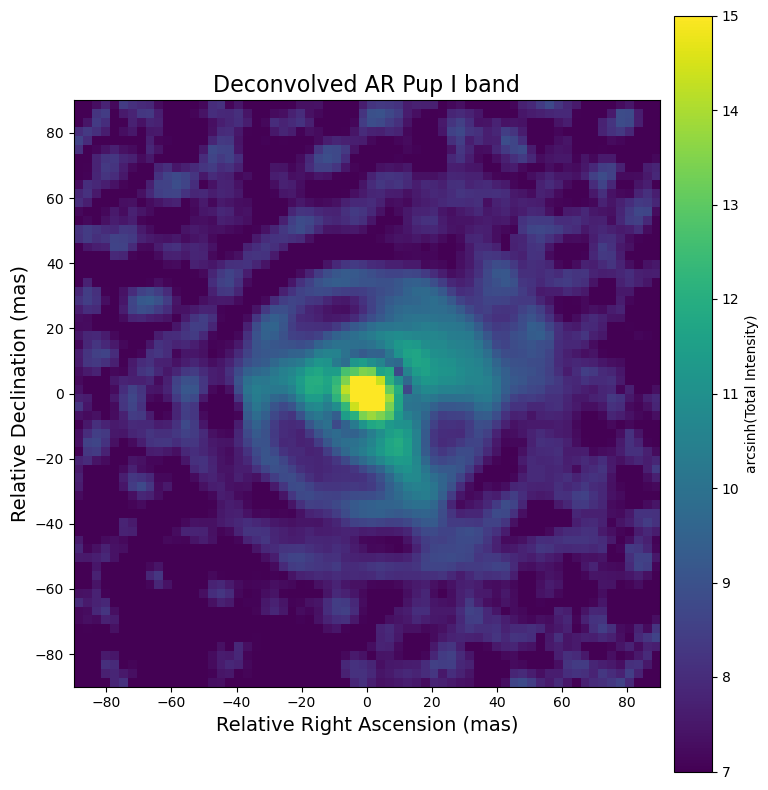

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits # Assuming you load H_data from a FITS file
from scipy.ndimage import rotate


# --- Assume H_data and other variables are defined here ---
# Example placeholders (YOU NEED TO REPLACE THESE WITH YOUR ACTUAL DATA/VALUES)
# For example, if H_data comes from a FITS file:
# try:
#     H_data, H_header = fits.getdata('/path/to/your/H_band_image.fits', header=True)
# except FileNotFoundError:
#     print("Error: H_band_image.fits not found. Please provide the correct path.")
#     exit()

# If H_data is already loaded from a previous part of your script, remove this placeholder.
# Let's assume H_data is already a numpy array from your context.
# H_data = np.random.rand(151, 151) * 100 # Placeholder for H_data, replace with your actual data
zoom_half_width_mas = 90 # Placeholder, replace with your actual value
# output_image_with_circle = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconv/ZIMPOL/some_image.png' # Placeholder

# Get image dimensions (ensure H_data is actually defined)
ny, nx = H_data.shape
plate_scale_mas_per_px = 3.6
H_data = rotate(H_data,-24)

# --- Start of your plotting code with fixes ---

# 1. Create the figure and axes objects
fig_image, ax_image = plt.subplots(figsize=(8, 8)) # This line was missing!

# Prepare the image for display (arcsinh scaling)
display_image = np.arcsinh(H_data) # H_data.copy()

# Determine display limits for the image (e.g., 99.5th percentile)
# It's good to re-evaluate these based on the actual arcsinh-scaled data
# to get a good dynamic range for visualization.
# If you want fixed min/max, you can use them directly.
vmax_display = np.percentile(display_image[display_image > 0], 99.5)
vmin_display = np.percentile(display_image[display_image > 0], 10)


# 2. Plot the image on the axes
im = ax_image.imshow(display_image, origin='lower', cmap='viridis',
                      # You can keep these fixed values if they work well for your data
                     vmin=7, vmax=15,
                     extent=(-nx/2 * plate_scale_mas_per_px, nx/2 * plate_scale_mas_per_px,
                             -ny/2 * plate_scale_mas_per_px, ny/2 * plate_scale_mas_per_px))

# 3. Add a colorbar for the image
# Call colorbar from plt, and pass the mappable object (im) and the axes (ax_image)
cbar_image = plt.colorbar(im, ax=ax_image, orientation='vertical', pad=0.02)
cbar_image.set_label('arcsinh(Total Intensity)')

# 4. Set plot limits and labels
ax_image.set_xlim(-zoom_half_width_mas, zoom_half_width_mas)
ax_image.set_ylim(-zoom_half_width_mas, zoom_half_width_mas)

# Set labels and title
ax_image.set_xlabel('Relative Right Ascension (mas)', fontsize=14) # Re-added labels for clarity
ax_image.set_ylabel('Relative Declination (mas)', fontsize=14)
ax_image.set_title(f'Deconvolved AR Pup I band', fontsize=16)

# Turn off grid for the image
ax_image.grid(False)

# Add any other elements you need (e.g., dotted circle, compass, scale bar)
# These lines would go here, using 'ax_image.plot', 'ax_image.arrow', 'ax_image.text', etc.
# For example, if you want the dotted circle from your previous code:
# circle_x_mas = (circle_x_pixels - nx/2) * plate_scale_mas_per_px
# circle_y_mas = (circle_y_pixels - ny/2) * plate_scale_mas_per_px
# ax_image.plot(circle_x_mas, circle_y_mas, 'w:', linewidth=2, label=f'{separation_mas:.0f} mas circle')
# ax_image.plot(0, 0, 'rx', markersize=10, label='Image Center') # Mark the image center (0,0 mas)


# --- Final display and saving ---
plt.tight_layout()
# Uncomment the line below to save the figure
plt.savefig('/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/02.SCI_AR_Pup/After_deconvv0/IRDIS/'+'H3_deconv.png', dpi=300)
plt.show()
plt.close(fig_image)

# Just test for substructures

In [46]:
test=True
if test:
    lim=100
    img2=PI*1.0
    Rlimit2=lim

    n=img2.shape[0]
    shift=n/2-0.5

    d=(n-1)*ps/2

    ell = EllipseModel()

    #b_plus=a*np.cos(np.deg2rad(75+10))
    #b_minus=a*np.cos(np.deg2rad(75-10))
    #points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b_plus,theta))
    #points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b_minus,theta))


    ac,bc=a,b
    reverse=False
    if a<b: 
        ac,bc=b,a
        print('reverse')
        reverse=True
    cosi=bc/ac
    ecc=np.sqrt(1-bc*bc/ac/ac)
    print('theta %.2f' % np.rad2deg(theta))
    angle=np.rad2deg(theta)
    #if angle<0: angle=angle+360
    if (a<b):
        if np.rad2deg(theta)<90:
            angle=angle+90
        else:
            angle=angle-90


    print('angle %.2f' % angle)

    xc_in=xc*1.0
    yc_in=yc*1.0
    print(xc, yc, a, b, theta,str(np.rad2deg(np.arccos(cosi))),ecc)

    logfile=open(savefig+star+'_'+annulus+'_ellipse_gauss_fit.txt','w+')
    logfile.writelines(star+'\n')
    logfile.writelines('Annulus for stellar polarisation '+annulus+'\n')
    logfile.writelines("center = (%f , %f) \n" % (xc*ps, yc*ps))
    logfile.writelines("angle of rotation = %f \n" % theta)
    logfile.writelines("half axes im mas= %f, %f \n" % (a*ps,b*ps))

    logfile.writelines('Inclination for the deprojection '+str(np.rad2deg(np.arccos(cosi)))+'\n')
    logfile.writelines('PA '+str(angle)+'\n')
    logfile.writelines('Eccentricity '+str(ecc)+'\n')



     #height of arc
    starposition=[(511.5-n/2),(511.5-n/2)] #center in python array index
    ringshift=math.dist(starposition,[xc,yc])
    sini=np.sqrt(1-cosi*cosi)

    logfile.writelines('\n')
    logfile.close()


    #substructures
    xcs=ycs=73
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(50)

    points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs,ycs,a,b,theta))

    xcs=43+5
    ycs=68+5
    a=300/ps
    b=a*np.cos(np.deg2rad(40))
    theta=np.deg2rad(60)

    points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs,-ycs,a,b,theta))





    d=(n)*ps/2
    names=['PI_I','PI_V','Q_phi_I','Q_phi_V','I_I','I_V','PI_dec_I','PI_dec_V']
    files=[PI_I,PI_V,Q_phi_I,Q_phi_V,I_I,I_V,PI_dec_I,PI_dec_V]   
    xc=yc=5
    a=80/ps
    b=a*np.cos(np.deg2rad(75))

    for name, img2 in zip(names,files):


        if name=='PI_V' or name=='Q_phi_V' or name=='I_V' or name=='PI_dec_V':
            theta=np.deg2rad(50+90)
        else:
            theta=np.deg2rad(50+90)



        points=ell.predict_xy(np.linspace(np.pi, 2 * np.pi, 50),params=(xc,yc,a,b,theta))
        points_plus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta+np.deg2rad(10)))
        points_minus=ell.predict_xy(np.linspace(0, 2 * np.pi, 50),params=(xc,yc,a,b,theta-np.deg2rad(10)))


        fig, ax = plt.subplots(1, 1,figsize=(10,10))
        image=np.arcsinh(img2)
        max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
        plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))

        #northeast2(lim,ps,coef=3)
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)

        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')
        #plt.plot(points_plus[:,0]*ps,points_plus[:,1]*ps, lw=1,ls='--', color='white')
        #plt.plot(points_minus[:,0]*ps,points_minus[:,1]*ps, lw=1,ls='--', color='white')
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')


        #plt.plot(xc*ps, yc*ps, '+',ms=10, color='red')

        ax.plot((511.5-n/2)*ps,(511.5-n/2)*ps, "+",ms=10, color="white")
        plt.xlabel('mas', fontsize=24)
        plt.ylabel("mas", fontsize=24)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        plt.title(name, fontsize=24)
        plt.savefig(savefig+ star+'_'+name+ "_ellipse.jpeg",bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()  


NameError: name 'PI' is not defined

In [47]:
import numpy as np
import matplotlib.pyplot as plt
# from astropy.modeling.models import EllipseModel
import math
import pandas as pd # Assuming pandas for DataFrame if it's used elsewhere
camera = 'ZIMPOL'
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera+'/'
dir =dirdat +'/deconvolved_'+'I'+'/'
I_I, R, x, y, d_in,X,Y= LoadImage_dec(dir,'I')
I_V, R, x, y, d_in,X,Y= LoadImage_dec(dir,'V')

# --- Placeholder definitions for demonstration ---
# You NEED to ensure these are defined correctly in your full script
# before this 'if test' block is executed.
# These are just so the snippet can run without immediate NameErrors.

ps = 3.6 # Example plate scale mas/pixel
# star = 'ExampleStar'
# annulus = 'some_annulus'
savefig = './' # Output directory for plots

# Dummy EllipseModel parameters (replace with your actual fitted values)
# These are the parameters for the ellipse calculations outside the plotting loop.
xc_fit, yc_fit = 511.5, 511.5 # Center in pixels for initial calculations
a_fit = 150 / ps # Example half-major axis in pixels
b_fit = a_fit * np.cos(np.deg2rad(75)) # Example half-minor axis in pixels
theta_fit = np.deg2rad(50) # Example position angle in radians

# Dummy data for I_I and I_V
# Replace these with your actual loaded FITS data or processed arrays.

# Dummy data for other images, if they are still loaded but not plotted.
# Keeping them defined here to avoid errors if they are used elsewhere in your full script
# but are not needed for *this specific* plotting section.
# PI_I = np.random.rand(1024, 1024)
# PI_V = np.random.rand(1024, 1024)
# Q_phi_I = np.random.rand(1024, 1024)
# Q_phi_V = np.random.rand(1024, 1024)
# PI_dec_I = np.random.rand(1024, 1024)
# PI_dec_V = np.random.rand(1024, 1024)
# --- End of Placeholder definitions ---

test=True
if test:
    lim=100 # This 'lim' defines the display extent (in pixels) for the zoom window.

    # Deriving 'n' directly from I_I's shape, removing PI dependency
    n = I_I.shape[0]

    shift = n/2 - 0.5 # Center for the extent calculation
    d = (n-1)*ps/2 # Max extent of the image in mas from center

    ell = EllipseModel() # Initialize EllipseModel

    # Original ellipse parameters for the text file and initial calculations
    # These use the _fit parameters, as they are likely from a separate fitting process.
    ac, bc = a_fit, b_fit
    reverse = False
    if a_fit < b_fit: # Use a_fit and b_fit here
        ac, bc = b_fit, a_fit
        print('reverse')
        reverse = True
    cosi = bc/ac
    ecc = np.sqrt(1 - bc*bc/ac/ac)
    print('theta %.2f' % np.rad2deg(theta_fit)) # Use theta_fit
    angle = np.rad2deg(theta_fit) # Use theta_fit
    if (a_fit < b_fit): # Use a_fit and b_fit
        if np.rad2deg(theta_fit) < 90: # Use theta_fit
            angle = angle + 90
        else:
            angle = angle - 90

    print('angle %.2f' % angle)

    # Use xc_fit, yc_fit for the logfile
    xc_in, yc_in = xc_fit * 1.0, yc_fit * 1.0
    print(xc_fit, yc_fit, a_fit, b_fit, theta_fit, str(np.rad2deg(np.arccos(cosi))), ecc)


    # Logfile writing (remains as is, using _fit parameters)
    try:
        logfile=open(savefig+star+'_'+annulus+'_ellipse_gauss_fit.txt','w+')
        logfile.writelines(star+'\n')
        logfile.writelines('Annulus for stellar polarisation '+annulus+'\n')
        logfile.writelines("center = (%f , %f) \n" % (xc_fit*ps, yc_fit*ps))
        logfile.writelines("angle of rotation = %f \n" % theta_fit)
        logfile.writelines("half axes im mas= %f, %f \n" % (a_fit*ps,b_fit*ps))
        logfile.writelines('Inclination for the deprojection '+str(np.rad2deg(np.arccos(cosi)))+'\n')
        logfile.writelines('PA '+str(angle)+'\n')
        logfile.writelines('Eccentricity '+str(ecc)+'\n')
        starposition=[(511.5-n/2),(511.5-n/2)] #center in python array index
        ringshift=math.dist(starposition,[xc_fit,yc_fit]) # Use xc_fit, yc_fit
        sini=np.sqrt(1-cosi*cosi)
        logfile.writelines('\n')
        logfile.close()
    except IOError as e:
        print(f"Warning: Could not write logfile. Check 'savefig' path and permissions. Error: {e}")


    # Substructure ellipses (orange dashed lines)
    # These parameters are fixed and plotted on all images
    xcs_sub1, ycs_sub1 = 73, 73
    a_sub1 = 300/ps
    b_sub1 = a_sub1*np.cos(np.deg2rad(40))
    theta_sub1 = np.deg2rad(50)
    points_subtr1=ell.predict_xy(np.linspace(np.deg2rad(130), np.deg2rad(230), 50),params=(xcs_sub1,ycs_sub1,a_sub1,b_sub1,theta_sub1))

    xcs_sub2, ycs_sub2 = 43+5, 68+5
    a_sub2 = 300/ps
    b_sub2 = a_sub2*np.cos(np.deg2rad(40))
    theta_sub2 = np.deg2rad(60)
    points_subtr2=ell.predict_xy(np.linspace(np.deg2rad(-45), np.deg2rad(70), 50),params=(-xcs_sub2,-ycs_sub2,a_sub2,b_sub2,theta_sub2))


    d_plot_extent = (n)*ps/2 # Total extent for plotting in mas

    # Filter `names` and `files` to ONLY include 'I_I' and 'I_V'
    names_to_plot=['I_I','I_V']
    files_to_plot=[I_I,I_V]

    # Redefine ellipse parameters for the plotted white ellipse
    xc_plot_ellipse, yc_plot_ellipse = 5, 5 # Center for the white ellipse
    a_plot_ellipse = 80/ps
    b_plot_ellipse = a_plot_ellipse*np.cos(np.deg2rad(75))
    theta_plot_ellipse = np.deg2rad(50+90) # Fixed orientation for this ellipse

    for name, img_to_plot in zip(names_to_plot,files_to_plot):

        # Predict points for the white ellipse
        points=ell.predict_xy(np.linspace(np.pi, 2 * np.pi, 50),params=(xc_plot_ellipse,yc_plot_ellipse,a_plot_ellipse,b_plot_ellipse,theta_plot_ellipse))

        fig, ax = plt.subplots(1, 1,figsize=(10,10))
        image_display = np.arcsinh(img_to_plot) # Use img_to_plot from the loop

        # Determine display limits for the image (from the zoomed region)
        # Ensure image_display is not empty or all zeros for min/max
        zoom_region = image_display[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)]
        if np.any(zoom_region):
            vmin_display = np.min(zoom_region)
            vmax_display = np.max(zoom_region)
        else: # Fallback if selected region is empty/all zero
             vmin_display, vmax_display = np.min(image_display), np.max(image_display)
             if vmax_display <= vmin_display: # Avoid invalid ranges for empty/flat images
                 vmax_display = vmin_display + 1e-6


        # Plot the image
        plt.imshow(image_display, vmin=vmin_display, vmax=vmax_display,
                   extent=(-d_plot_extent, d_plot_extent, d_plot_extent, -d_plot_extent),
                   cmap='viridis', # Added cmap for better visualization
                   origin='upper')

        # Adjust plot limits based on 'lim' (which is in pixels here)
        # Convert pixel limits to mas for the plot
        plt.xlim(-lim * ps, lim * ps)
        plt.ylim(-lim * ps, lim * ps)

        # Plot the white ellipse (main structure)
        plt.plot(points[:,0]*ps,points[:,1]*ps, lw=2, color='white')

        # Plot the orange dashed ellipses (substructures)
        plt.plot(points_subtr1[:,0]*ps,points_subtr1[:,1]*ps, lw=2,ls='--', color='orange')
        plt.plot(points_subtr2[:,0]*ps,points_subtr2[:,1]*ps, lw=2,ls='--', color='orange')

        # Plot the image center (was `(511.5-n/2)*ps`)
        plt.plot((511.5-n/2)*ps,(511.5-n/2)*ps, "+",ms=10, color="white")

        plt.xlabel('mas', fontsize=24)
        plt.ylabel("mas", fontsize=24)
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        plt.title(name, fontsize=24) # Title will be 'I_I' or 'I_V'
        plt.savefig(savefig+ star+'_'+name+ "_ellipse.jpeg",bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

theta 50.00
angle 50.00
511.5 511.5 41.666666666666664 10.784126879271696 0.8726646259971648 75.0 0.9659258262890683


NameError: name 'annulus' is not defined

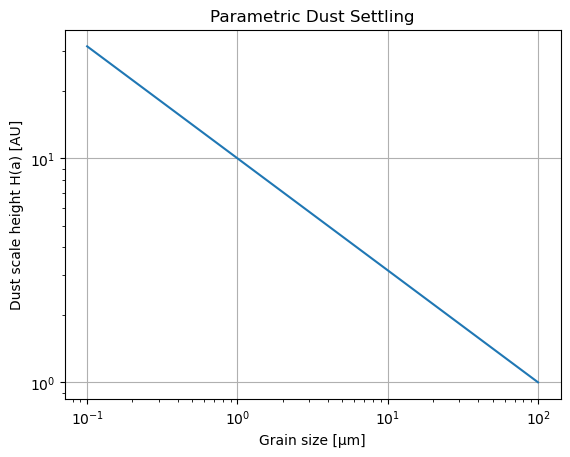

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
r = 100  # au
a = np.logspace(-1, 2, 100)  # grain sizes [μm] from 0.1 to 100 μm
a_strat = 1.0  # μm
exp_strat = 0.5
H_gas = 10  # AU at r=100 au

# Dust scale height
H_d = H_gas * (a / a_strat) ** (-exp_strat)

# Plot
plt.figure()
plt.loglog(a, H_d)
plt.xlabel('Grain size [μm]')
plt.ylabel('Dust scale height H(a) [AU]')
plt.title('Parametric Dust Settling')
plt.grid(True)
plt.show()



--- Processing I-band for 01.SCI_AR_Pup ---

--- Light Percentages for I-band Total Intensity (01.SCI_AR_Pup) ---
Total Intensity Sum in mask_total_intensity_region: 1674748.12
Intensity Sum (Central Star, R <= 10.00 px): 1368953.36
Intensity Sum (Inner Disk, 10.00 < R <= 30.00 px): 250272.54
Intensity Sum (Outer Disk, 30.00 < R <= 60.00 px): 55522.22
Light Percent (Central Star): 81.74%
Light Percent (Inner Disk): 14.94%
Light Percent (Outer Disk): 3.32%
Total accounted for (%): 100.00%

Average separation of light in Inner Disk (10.00-30.00 px): 58.47 mas
Average separation of light in Outer Disk (30.00-60.00 px): 143.21 mas


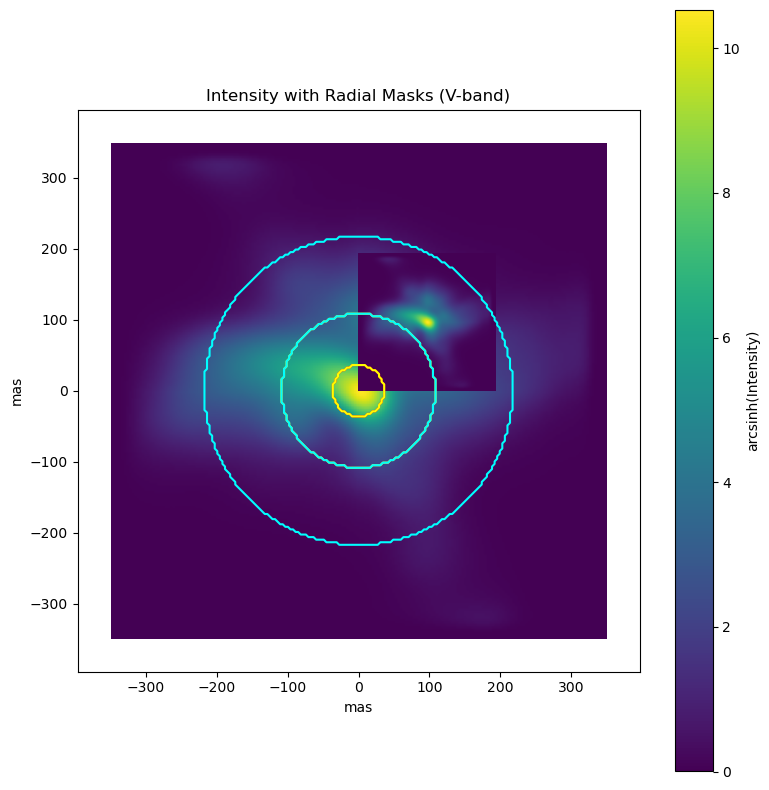


--- Processing V-band for 01.SCI_AR_Pup ---

--- Light Percentages for V-band Total Intensity (01.SCI_AR_Pup) ---
Total Intensity Sum in mask_total_intensity_region: 1660573.02
Intensity Sum (Central Star, R <= 10.00 px): 1240445.90
Intensity Sum (Inner Disk, 10.00 < R <= 30.00 px): 360107.47
Intensity Sum (Outer Disk, 30.00 < R <= 60.00 px): 60019.64
Light Percent (Central Star): 74.70%
Light Percent (Inner Disk): 21.69%
Light Percent (Outer Disk): 3.61%
Total accounted for (%): 100.00%

Average separation of light in Inner Disk (10.00-30.00 px): 58.63 mas
Average separation of light in Outer Disk (30.00-60.00 px): 138.75 mas


IndexError: list index out of range

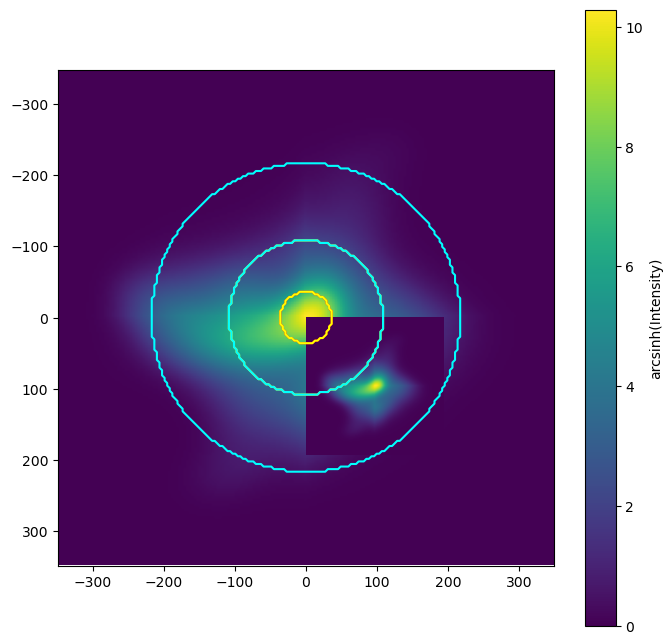

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os # For creating folders

# --- Assume these are defined globally or passed into a larger function ---
star = '01.SCI_AR_Pup' # Example star name
ps = 3.6 # mas/pixel
starnames = {'01.SCI_AR_Pup': 'AR Pup', '02.SCI_AR_Pup': 'Ar Pup'} # Example dictionary
band = ['I','V'] # Example dictionary for bands
fittypes = ['1','2'] # Assuming '1' corresponds to 'I' band

def createfolder(path):
    if not os.path.exists(path):
        os.makedirs(path)

def LoadImage(directory, filename):
    filepath = os.path.join(directory, filename)
    try:
        with fits.open(filepath) as hdu:
            return hdu[0].data
    except FileNotFoundError:
        print(f"Error: {filepath} not found.")
        return None
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None

dirdat = f'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/{star}/Deconvolution_corr_telv1/ZIMPOLv2/deconvolved_I'
dirdatI = f'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/{star}/filtered/'
figfolder = f'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/{star}/Substructures/'
createfolder(figfolder)

# --- Loop through fittypes (bands) ---
for fittype in fittypes:
    print(f"\n--- Processing {band[int(fittype)-1]}-band for {star} ---")

    # Load Total Intensity (I) image
    # Assuming LoadImage returns the data array
    I = LoadImage(dirdat, f"{star}_{band[int(fittype)-1]}_decon.fits")
    if I is None:
        continue # Skip if image loading failed

    n_pixels = I.shape[0] # Get image dimension (assuming square image)
    xc = (n_pixels - 1) / 2.0 # Center X coordinate
    yc = (n_pixels - 1) / 2.0 # Center Y coordinate

    ps = 3.6

    # Create coordinate grids relative to the center
    xr = np.arange(n_pixels) - xc
    yr = np.arange(n_pixels) - yc
    Xr_grid, Yr_grid = np.meshgrid(xr, yr)
    R_pixels = np.sqrt(Xr_grid**2 + Yr_grid**2) # Radial distance in pixels

    # Central Star Region (e.g., FWHM of the star or slightly larger)
    fwhm_pixels = 4.16
    radius_central_pixels = 10 # Radius for the star's core
    radius_inner_disk_pixels = 30
    radius_outer_disk_pixels = 60

    # You can also use specific mas values and convert them to pixels
    # E.g., if you want a 50 mas inner radius: radius_inner_disk_pixels = 50 / ps

    # --- Create Masks ---
    mask_central_star = R_pixels <= radius_central_pixels
    mask_inner_disk = (R_pixels > radius_central_pixels) & (R_pixels <= radius_inner_disk_pixels)
    mask_outer_disk = (R_pixels > radius_inner_disk_pixels) & (R_pixels <= radius_outer_disk_pixels)
    mask_total_intensity_region = R_pixels <= radius_outer_disk_pixels # Total region for percentage calculation

    # --- Calculate Light Percent ---
    total_intensity_in_region = np.sum(I[mask_total_intensity_region])
    intensity_central_star = np.sum(I[mask_central_star])
    intensity_inner_disk = np.sum(I[mask_inner_disk])
    intensity_outer_disk = np.sum(I[mask_outer_disk])

    # Avoid division by zero if no signal in the total region
    if total_intensity_in_region > 0:
        percent_central_star = (intensity_central_star / total_intensity_in_region) * 100
        percent_inner_disk = (intensity_inner_disk / total_intensity_in_region) * 100
        percent_outer_disk = (intensity_outer_disk / total_intensity_in_region) * 100
    else:
        percent_central_star = 0
        percent_inner_disk = 0
        percent_outer_disk = 0

    print(f"\n--- Light Percentages for {band[int(fittype)-1]}-band Total Intensity ({star}) ---")
    print(f"Total Intensity Sum in mask_total_intensity_region: {total_intensity_in_region:.2f}")
    print(f"Intensity Sum (Central Star, R <= {radius_central_pixels:.2f} px): {intensity_central_star:.2f}")
    print(f"Intensity Sum (Inner Disk, {radius_central_pixels:.2f} < R <= {radius_inner_disk_pixels:.2f} px): {intensity_inner_disk:.2f}")
    print(f"Intensity Sum (Outer Disk, {radius_inner_disk_pixels:.2f} < R <= {radius_outer_disk_pixels:.2f} px): {intensity_outer_disk:.2f}")
    print(f"Light Percent (Central Star): {percent_central_star:.2f}%")
    print(f"Light Percent (Inner Disk): {percent_inner_disk:.2f}%")
    print(f"Light Percent (Outer Disk): {percent_outer_disk:.2f}%")
    print(f"Total accounted for (%): {percent_central_star + percent_inner_disk + percent_outer_disk:.2f}%")


    # --- Calculate Central Star Separation (This is typically 'radius') ---

    # Here's how you'd calculate the average separation of light in a region:
    # Weighted average radius: sum(intensity * radius) / sum(intensity)
    if intensity_inner_disk > 0:
        avg_sep_inner_disk_pixels = np.sum(I[mask_inner_disk] * R_pixels[mask_inner_disk]) / intensity_inner_disk
        avg_sep_inner_disk_mas = avg_sep_inner_disk_pixels * ps
        print(f"\nAverage separation of light in Inner Disk ({radius_central_pixels:.2f}-{radius_inner_disk_pixels:.2f} px): {avg_sep_inner_disk_mas:.2f} mas")
    else:
        print("\nNo light in Inner Disk region to calculate average separation.")

    if intensity_outer_disk > 0:
        avg_sep_outer_disk_pixels = np.sum(I[mask_outer_disk] * R_pixels[mask_outer_disk]) / intensity_outer_disk
        avg_sep_outer_disk_mas = avg_sep_outer_disk_pixels * ps
        print(f"Average separation of light in Outer Disk ({radius_inner_disk_pixels:.2f}-{radius_outer_disk_pixels:.2f} px): {avg_sep_outer_disk_mas:.2f} mas")
    else:
        print("No light in Outer Disk region to calculate average separation.")

    # --- Optional: Visualize the masks (similar to your ellipse plotting) ---
    fig_masks, ax_masks = plt.subplots(figsize=(8,8))
    # Display the arcsinh-scaled intensity image
    I_display = np.arcsinh(I)
    max_display = np.max(I_display[I_display > 0])
    min_display = np.min(I_display[I_display > 0])
    # Ensure extent matches the mas scale for plotting
    d_mas_plot = (n_pixels / 2) * ps
    ax_masks.imshow(I_display, vmin=min_display, vmax=max_display,
                    extent=(-d_mas_plot, d_mas_plot, -d_mas_plot, d_mas_plot),
                    origin='lower', cmap='viridis')
    plt.colorbar(ax_masks.imshow(I_display, cmap='viridis'), ax=ax_masks, label='arcsinh(Intensity)')

    # Overlay contours of the masks
    ax_masks.contour(mask_central_star, colors='red', levels=[0.5], linewidths=1.5,
                     extent=(-d_mas_plot, d_mas_plot, -d_mas_plot, d_mas_plot))
    ax_masks.contour(mask_inner_disk, colors='yellow', levels=[0.5], linewidths=1.5,
                     extent=(-d_mas_plot, d_mas_plot, -d_mas_plot, d_mas_plot))
    ax_masks.contour(mask_outer_disk, colors='cyan', levels=[0.5], linewidths=1.5,
                     extent=(-d_mas_plot, d_mas_plot, -d_mas_plot, d_mas_plot))

    ax_masks.set_title(f'Intensity with Radial Masks ({band[int(fittype)]}-band)')
    ax_masks.set_xlabel('mas')
    ax_masks.set_ylabel('mas')

    # Set plot limits to zoom in, similar to your 'lim' variable's purpose
    # Use lim value from your original code if appropriate
    if star=='V709_Car':
        plot_lim_pixels=60
    elif star=='01.SCI_AR_Pup':
        plot_lim_pixels=110
    else:
        plot_lim_pixels=40
    ax_masks.set_xlim(-plot_lim_pixels * ps, plot_lim_pixels * ps)
    ax_masks.set_ylim(-plot_lim_pixels * ps, plot_lim_pixels * ps)

    plt.tight_layout()
    plt.savefig(os.path.join(figfolder, f"{star}_{band[int(fittype)]}_intensity_masks.png"), dpi=300)
    plt.show()
    plt.close(fig_masks)

In [258]:
I_data2018

array([[6.40574107e-09, 2.79079573e-08, 8.02049265e-08, ...,
        5.78413126e-11, 3.82254922e-12, 1.73994301e-13],
       [3.82751857e-08, 1.80685661e-07, 5.61231225e-07, ...,
        5.72649454e-10, 3.74478281e-11, 1.64556562e-12],
       [1.44701063e-07, 7.35605440e-07, 2.44138398e-06, ...,
        3.63719892e-09, 2.42961799e-10, 1.06218212e-11],
       ...,
       [4.31682169e-09, 3.65221190e-08, 2.07228275e-07, ...,
        1.27900673e-06, 1.43251603e-07, 9.83271865e-09],
       [4.42749192e-10, 3.85347493e-09, 2.23288948e-08, ...,
        2.09726054e-07, 2.63171044e-08, 2.04992877e-09],
       [2.91177209e-11, 2.52116959e-10, 1.48433675e-09, ...,
        2.17591548e-08, 3.13941701e-09, 2.86330889e-10]], shape=(194, 194))